In [1]:
import os
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import anndata as ad
# import gdown
import anndata2ri
import rpy2
from rpy2.robjects import r
import random
import session_info



anndata2ri.activate() # originally done with R 3.5.2
%load_ext rpy2.ipython

In [2]:
sc.settings.set_figure_params(dpi=300, frameon=False)
sc.set_figure_params(dpi=300)
sc.set_figure_params(figsize=(4, 4))

In [3]:
## download and read h5ad files

# gdown.download(id='1ZUC_HaKDudXRmRLzm78Wq0RcQV_pyD2q', 
#                output='data/totalVI_cite_pbmc_ref.h5ad', 
#                quiet=False)


# gdown.download(id='1RKhxi4h5TxL8w2n9R4ZCIAeKFK62NWUj', 
#                output='data/totalVI_cite_pbmc_query.h5ad', 
#                quiet=False)


# gdown.download(id='1zSebrJaJih6ONE5q-ws3LHZ0eu_UhDCP', 
#                output='data/totalVI_cite_pbmc_integrated.h5ad', 
#                quiet=False)

In [4]:
%%R
suppressPackageStartupMessages({
    library(SingleCellExperiment)
    library(Seurat)
    library(limma)
    library(ggplot2)
    library(miloR)
    library(ComplexHeatmap)
    library(RColorBrewer)
})

In [5]:
%%R
devtools::load_all(path="../../scDECAF")

GetMSigDB <- function(database="Hallmarks"){
  
  
  Hallmark_Geneset_DIR <- "../../benchmarking/GeneSets/h.all.v7.2.symbols.gmt"
  C2_DIR <- "../../benchmarking/GeneSets/c2.all.v7.2.symbols.gmt"

  if (database == "Hallmarks") {
    Hallmark_Genesets <- list()
    conn <- file(Hallmark_Geneset_DIR,open="r")
    linn <-readLines(conn)
    for (i in 1:length(linn)){
      iLine <- linn[i]
      iLine <- strsplit(iLine, "\t")
      iName <- iLine[[1]][1]
      iList <- iLine[[1]]
      iList <- iList[3:length(iList)]
      Hallmark_Genesets[[iName]] <- iList
     # Hallmark_Genesets <- c(Hallmark_Genesets, list(GeneSet(setName=iName, geneIds=iList)))
    }
    close(conn)
    return(Hallmark_Genesets)
    
  } else if (database == "C2") {
    C2_Genesets <- list()
    conn <- file(C2_DIR,open="r")
    linn <-readLines(conn)
    for (i in 1:length(linn)){
      iLine <- linn[i]
      iLine <- strsplit(iLine, "\t")
      iName <- iLine[[1]][1]
      iList <- iLine[[1]]
      iList <- iList[3:length(iList)]
      C2_Genesets[[iName]] <- iList
      #C2_Genesets <- c(C2_Genesets, list(GeneSet(setName=iName, geneIds=iList)))
    }
    close(conn)
    return(C2_Genesets)
  } else if (database == "Both"){
    Genesets <- list()
    conn <- file(Hallmark_Geneset_DIR,open="r")
    linn <-readLines(conn)
    for (i in 1:length(linn)){
      iLine <- linn[i]
      iLine <- strsplit(iLine, "\t")
      iName <- iLine[[1]][1]
      iList <- iLine[[1]]
      iList <- iList[3:length(iList)]
      Genesets[[iName]] <- iList

    }
    close(conn)

    conn <- file(C2_DIR,open="r")
    linn <-readLines(conn)
    for (i in 1:length(linn)){
      iLine <- linn[i]
      iLine <- strsplit(iLine, "\t")
      iName <- iLine[[1]][1]
      iList <- iLine[[1]]
      iList <- iList[3:length(iList)]
      Genesets[[iName]] <- iList

    }
    close(conn)
    
    return(Genesets)
  }

}


HM_genesets <- GetMSigDB(database="Hallmarks")

ℹ Loading scDECAF


In [6]:
import anndata as ad
ad.__version__

'0.8.0'

In [7]:
umap_adata = sc.read('data/totalVI_cite_pbmc_integrated.h5ad')
umap_adata

AnnData object with n_obs × n_vars = 209763 × 2
    obs: 'celltype', 'dataset'
    obsm: 'X_umap'

In [8]:
umap_adata

AnnData object with n_obs × n_vars = 209763 × 2
    obs: 'celltype', 'dataset'
    obsm: 'X_umap'

In [9]:
adata = sc.read('data/totalVI_cite_pbmc_ref.h5ad')
adata

AnnData object with n_obs × n_vars = 152094 × 4000
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'X_index', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'Protein log library size', 'Number proteins detected', 'RNA log library size', '_scvi_labels', '_scvi_batch', 'dataset_name'
    var: 'mt', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltype.l2_colors', 'hvg', 'log1p', 'orig.ident_colors'
    obsm: 'X_totalvi_scarches', 'X_umap', 'protein_counts'
    layers: 'counts'

In [10]:
query = sc.read('data/totalVI_cite_pbmc_query.h5ad')
query

AnnData object with n_obs × n_vars = 57669 × 4000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.4', 'seurat_clusters', 'set', 'Resp', 'disease', 'subj_code', 'covidpt_orhealth', 'mito', 'ncount', 'nfeat', 'bust_21', 'og_clust', 'severmod_other', 'og_clusts', 'nCount_ADT', 'nFeature_ADT', 'UMAP1', 'UMAP2', 'final_clust', 'final_clust_v2', 'new_pt_id', 'Resp_og', 'final_clust_withnum', 'final_clust_review', 'Age', 'Gender', 'Gender_num', 'doublet_scores', 'predicted_doublets', 'celltype.l2', 'dataset_name', '_scvi_labels', '_scvi_batch', 'predicted_l2_scarches'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltype.l2_colors', 'final_clust_review_colors', 'log1p'
    obsm: 'X_totalvi_scarches', 'X_umap', 'X_umap_project', 'pro_exp', 'protein_counts'
    layers: 'counts'

In [11]:
pd.set_option('display.max_columns', None)  
# query.obs

In [12]:
pd.crosstab(query.obs['orig.ident'], query.obs.Resp) # two batches all from Atlanta cohort

Resp,Healthy,mod,severe
orig.ident,,,
set1,14818,6998,5498
set2,14683,4427,11245


In [13]:
mdata_arnum = pd.read_csv('arunachalam_samplemeta.csv', index_col =0, delimiter=';')
mdata_arnum

,Infection,Response,ICU,Day,Age,Sex,Ethnicity
ID,,,,,,,
cov1,COVID-19,"Severe, dec.",Y,15,60,F,B
cov2,COVID-19,Severe,N,15,75,F,W
cov3,COVID-19,Severe,N,16,59,M,B
cov4,COVID-19,Severe,N,8,48,M,B
cov5,COVID-19,Moderate,N,9,53,F,B
cov6,COVID-19,Moderate,N,2,75,F,W
cov7,COVID-19,Moderate,N,9,47,F,B
hd1,Healthy,–,–,–,84,F,W
hd2,Healthy,–,–,–,68,F,W


In [14]:
mdata_dict = mdata_arnum.to_dict()

In [15]:
query.obs['days_from_onset'] = query.obs.new_pt_id.map(mdata_dict['Day'])

In [16]:
query.obsm['X_umap'] = query.obsm['X_umap'].to_numpy()

In [17]:
sc.pl.umap(
    query,
    color=['final_clust', 'final_clust_v2','celltype.l2','Resp','disease','orig.ident'],# 'final_clust_v2','celltype.l2'
    frameon=False,
    wspace = 0.2,
    ncols=1,
    size = 2,
#     save='_pbmc_citeseq.png'
)

In [18]:
query_latent_adata = umap_adata.copy()

In [19]:
umap_adata.obs['Resp'] = None
umap_adata.obs['Resp'][umap_adata.obs.dataset.isin(['query'])] = query.obs.Resp.values

/tmp/ipykernel_51890/817180651.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  umap_adata.obs['Resp'][umap_adata.obs.dataset.isin(['query'])] = query.obs.Resp.values


In [20]:
# map colors
col_map = pd.read_table('gut_scpoli_color.txt', header=None, index_col=0)
col_map = dict(zip(col_map.index, col_map[1]))
col_map_vals = list(col_map.values())

In [21]:
col_map_newkeys = list(set(umap_adata.obs.celltype.tolist() + umap_adata.obs.Resp.tolist()))

In [22]:
col_map_newkeys

['Eryth',
 'mod',
 'CD16 Mono',
 'Platelet',
 'CD8 Naive',
 'CD8 TEM',
 'severe',
 'ILC',
 'CD4 Proliferating',
 'cDC1',
 'gdT',
 'Plasmablast',
 'CD8 Proliferating',
 'dnT',
 'B naive',
 'B intermediate',
 'Treg',
 None,
 'HSPC',
 'NK',
 'NK Proliferating',
 'CD4 TEM',
 'NK_CD56bright',
 'B memory',
 'Healthy',
 'CD14 Mono',
 'CD8 TCM',
 'MAIT',
 'ASDC',
 'CD4 TCM',
 'cDC2',
 'CD4 Naive',
 'CD4 CTL',
 'pDC']

In [23]:
len(col_map_newkeys)

34

In [24]:
col_map_newkeys = [
    
    'CD8 Proliferating', 'CD8 Naive','NK Proliferating','NK','NK_CD56bright',
    
    'ILC', 'CD8 TCM', 'CD8 TEM', 'CD4 TEM',
    
    'CD4 TCM','CD4 Naive', 'CD14 Mono', 'CD4 Proliferating', 'CD4 CTL',
    
    'CD14 Mono', 'CD16 Mono', 'Treg', 'MAIT', 'cDC1', 
    
    'cDC2', 'pDC', 'Plasmablast', 'Platelet', 'HSPC',
     
    'B naive','gdT', 'B memory', 'B intermediate', 'Eryth',
     
    'ASDC', 'dnT',
    
    'Healthy','severe','mod', 
    
    'query','reference',
   
]

In [25]:
len(col_map_newkeys)

36

In [26]:
col_map_vals = [
    
    #1-5
    "#edc951","#eb6841","#cc2a36","#4f372d","#00a0b0",
    
    #6-9
    "#51394E", "#C8AF8A", "#658385", "#B04838",
    
    #10-14
    "#3F6F76", "#C65840", "#F4CE4B", "#62496F", "#69B7CE",
    
    #15-19
   "#d2981a", "#a53e1f", "#457277", "#8f657d", "#8dcee2",
    
    
    #20-24
    "#91323A", "#3A4960", "#6D7345", "#554540", "#D7C969",
    
     #24-28
    "#C1395E", "#AEC17B", "#E07B42", "#89A7C2", "#F0CA50",
    
    #29-33
   "#67161C", "#3F6148", "#A4804C", "#4B5F80", "#DBD3A4",
    
    #34-38
    
     "#7A989A", "#849271", "#CF9546", "#C67052", "#C1AE8D",
    
    
    
    
        "#42819F", "#86AA7D", "#CBB396", "#4D280F", "#555234",
    #      "#A4B7E1", "#B8B87A", "#EFBD37", "#A85E5E", "#EFDE80",


    "#E69253", "#EDB931", "#E4502E", "#4378A0", "#272A2A",
    "#21344F", "#8AAD05", "#DF5D22", "#E17976", "#E2CE1B",
]

In [27]:
len(col_map_vals)

54

In [28]:
col_df = pd.DataFrame({'terms':col_map_newkeys, 'color_key': col_map_vals[0:len(col_map_newkeys)]})
col_df.index = col_df.terms

In [29]:
col_map = col_df.color_key.to_dict()

In [30]:
col_map['nan'] = 'lightgray'

In [31]:
col_map['Platelet'] = "#C1AE8D"

In [32]:
col_map['query'] = "#654E92"
col_map['reference'] = "#A5C0DD"

In [33]:
col_map

{'CD8 Proliferating': '#edc951',
 'CD8 Naive': '#eb6841',
 'NK Proliferating': '#cc2a36',
 'NK': '#4f372d',
 'NK_CD56bright': '#00a0b0',
 'ILC': '#51394E',
 'CD8 TCM': '#C8AF8A',
 'CD8 TEM': '#658385',
 'CD4 TEM': '#B04838',
 'CD4 TCM': '#3F6F76',
 'CD4 Naive': '#C65840',
 'CD14 Mono': '#d2981a',
 'CD4 Proliferating': '#62496F',
 'CD4 CTL': '#69B7CE',
 'CD16 Mono': '#a53e1f',
 'Treg': '#457277',
 'MAIT': '#8f657d',
 'cDC1': '#8dcee2',
 'cDC2': '#91323A',
 'pDC': '#3A4960',
 'Plasmablast': '#6D7345',
 'Platelet': '#C1AE8D',
 'HSPC': '#D7C969',
 'B naive': '#C1395E',
 'gdT': '#AEC17B',
 'B memory': '#E07B42',
 'B intermediate': '#89A7C2',
 'Eryth': '#F0CA50',
 'ASDC': '#67161C',
 'dnT': '#3F6148',
 'Healthy': '#A4804C',
 'severe': '#4B5F80',
 'mod': '#DBD3A4',
 'query': '#654E92',
 'reference': '#A5C0DD',
 'nan': 'lightgray'}

In [34]:
len(col_map)

36

In [35]:
# col_map['severe'] ='red'

In [36]:
umap_adata.obs.Resp = umap_adata.obs.Resp.astype('category')

In [37]:
umap_adata.obs.dataset = umap_adata.obs.dataset.cat.reorder_categories(['query','reference'])

In [38]:
umap_adata.uns['celltype_colors'] = umap_adata.obs.celltype.cat.categories.map(col_map)
umap_adata.uns['Resp_colors'] = umap_adata.obs.Resp.cat.categories.map(col_map)
umap_adata.uns['dataset_colors'] = umap_adata.obs.dataset.cat.categories.map(col_map)

In [39]:
umap_adata.uns['celltype_colors']

Index(['#67161C', '#89A7C2', '#E07B42', '#C1395E', '#69B7CE', '#C65840',
       '#62496F', '#3F6F76', '#B04838', '#eb6841', '#edc951', '#C8AF8A',
       '#658385', '#d2981a', '#a53e1f', '#F0CA50', '#D7C969', '#51394E',
       '#8f657d', '#4f372d', '#cc2a36', '#00a0b0', '#6D7345', '#C1AE8D',
       '#457277', '#8dcee2', '#91323A', '#3F6148', '#AEC17B', '#3A4960'],
      dtype='object')

In [40]:
umap_adata.obs.celltype.cat.categories.map(col_map)

Index(['#67161C', '#89A7C2', '#E07B42', '#C1395E', '#69B7CE', '#C65840',
       '#62496F', '#3F6F76', '#B04838', '#eb6841', '#edc951', '#C8AF8A',
       '#658385', '#d2981a', '#a53e1f', '#F0CA50', '#D7C969', '#51394E',
       '#8f657d', '#4f372d', '#cc2a36', '#00a0b0', '#6D7345', '#C1AE8D',
       '#457277', '#8dcee2', '#91323A', '#3F6148', '#AEC17B', '#3A4960'],
      dtype='object')

In [41]:
umap_adata.obs.celltype.cat.categories

Index(['ASDC', 'B intermediate', 'B memory', 'B naive', 'CD4 CTL', 'CD4 Naive',
       'CD4 Proliferating', 'CD4 TCM', 'CD4 TEM', 'CD8 Naive',
       'CD8 Proliferating', 'CD8 TCM', 'CD8 TEM', 'CD14 Mono', 'CD16 Mono',
       'Eryth', 'HSPC', 'ILC', 'MAIT', 'NK', 'NK Proliferating',
       'NK_CD56bright', 'Plasmablast', 'Platelet', 'Treg', 'cDC1', 'cDC2',
       'dnT', 'gdT', 'pDC'],
      dtype='object')

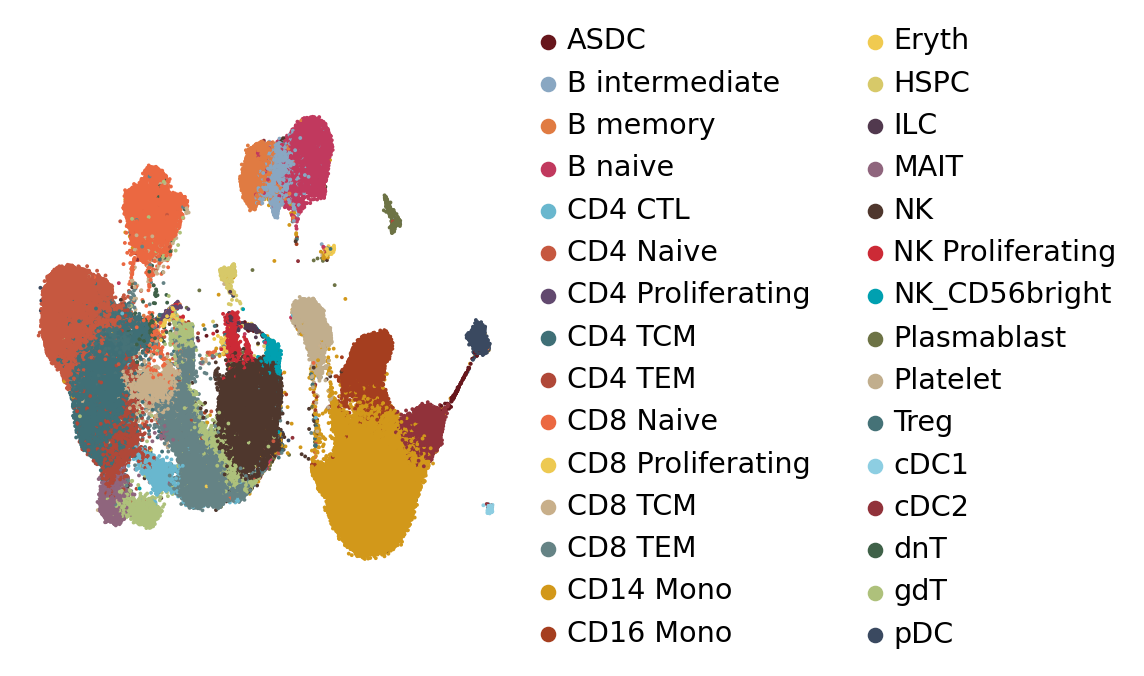

In [42]:
# inds = np.random.permutation(np.arange(umap_adata.shape[0]))
sc.pl.umap(
    umap_adata,
    color=["celltype"], 
    title = '',
    frameon=False,
    ncols=1,
#     legend_loc=None,
#     wspace = 0.3,
    size = 12,
    save='_pbmc_citeseq_query_and_ref_legend.png'
)

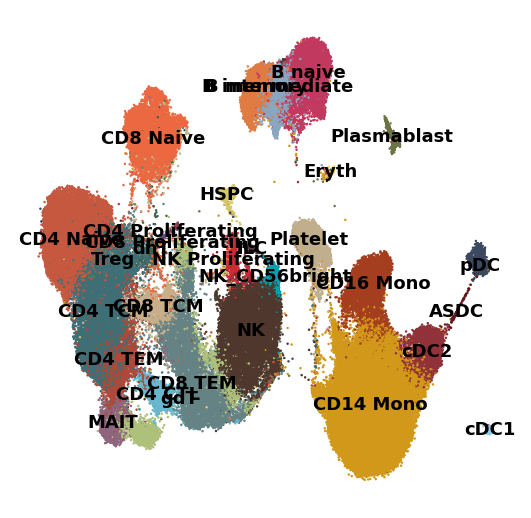

In [292]:
sc.pl.umap(
    umap_adata,
    color=["celltype"], 
    title = '',
    frameon=False,
    ncols=1,
    legend_loc='on data',
    legend_fontsize = 'xx-small',
#     wspace = 0.3,
    size = 5,
#     save='_pbmc_citeseq_query_and_ref_legend.png'
)

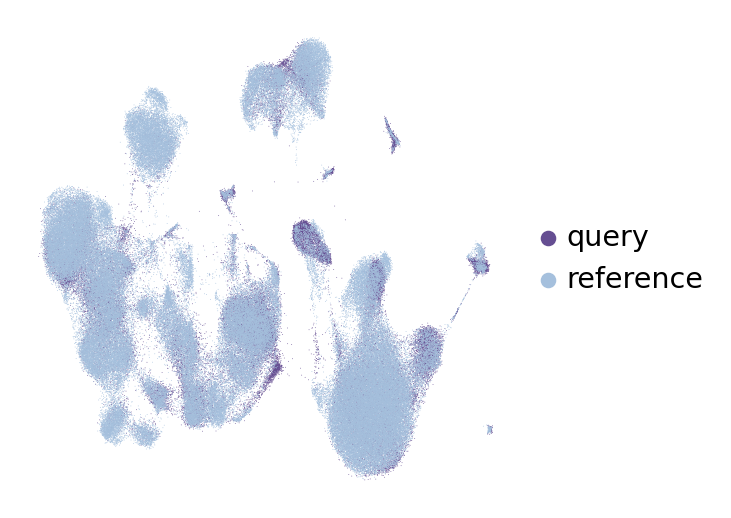

In [43]:
sc.pl.umap(
    umap_adata,
    color=["dataset"], 
    title = '',
    frameon=False,
    ncols=1,
#     legend_loc=None,
#     wspace = 0.3,
#     size = 1.5,
    save='_pbmc_citeseq_ann_query_and_ref.png'
)

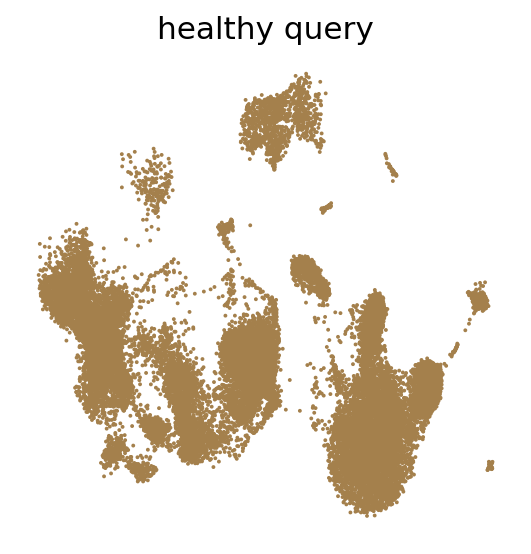

In [44]:
# inds = np.random.permutation(np.arange(umap_adata.shape[0]))
sc.pl.umap(
    umap_adata[umap_adata.obs.Resp.isin(['Healthy'])],
    color=["Resp"], 
#     groups = ['Healthy'],
    title = 'healthy query',
    frameon=False,
    ncols=2,
    legend_loc=None,
#     wspace = 0.3,
    size = 12,
    save='_pbmc_citeseq_ann_healthyquery.png'
)

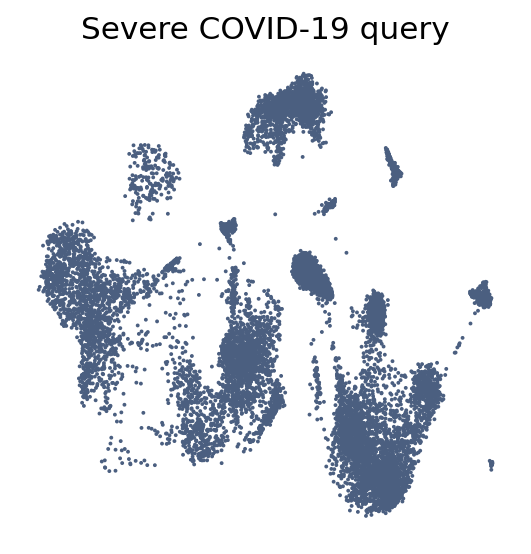

In [45]:
sc.pl.umap(
    umap_adata[umap_adata.obs.Resp.isin(['severe'])],
    color=["Resp"], 
    title = 'Severe COVID-19 query',
#     groups = ['severe'],
    frameon=False,
    ncols=2,
    legend_loc=None,
#     wspace = 0.3,
    size = 12,
    save='_pbmc_citeseq_ann_covidquery.png'
)

In [46]:
obsdata = umap_adata.obs

In [47]:
exprs_norm_scanpy = query.X.A.T

In [48]:
exprs_norm_scanpy.shape

(4000, 57669)

In [49]:
feature_names = query.var_names

In [50]:
obsnames = query.obs_names

In [51]:
cell_embedding = umap_adata.X[umap_adata.obs.dataset == 'query']

In [52]:
cell_embedding.shape

(57669, 2)

In [53]:
outcomes = query.obs.Resp

In [54]:
%%R -i outcomes
disease_onehot <- model.matrix(~ 0 + outcomes)
disease_onehot <- as.matrix(disease_onehot)
dim(disease_onehot)

[1] 57669     3


sctransform normalisation

In [55]:
query_ = query
query_.X = query.layers['counts']
query_.X = query_.X.A

In [56]:
type(query_.X)

numpy.ndarray

In [57]:
del query_.uns
del query_.layers
del query_.obsm

In [58]:
%%R -i query_
pbmc <- as.Seurat(query_, counts = "X", data = NULL)
pbmc

/home/users/allstaff/hediyehzadeh.s/.local/lib/python3.9/site-packages/anndata2ri/r2py.py:102: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(exprs, obs, var, uns, obsm or None, layers=layers)


An object of class Seurat 
4000 features across 57669 samples within 1 assay 
Active assay: originalexp (4000 features, 0 variable features)


In [59]:
%%R
pbmc = RenameAssays(object = pbmc, originalexp = 'RNA')

R[write to console]: Renaming default assay from originalexp to RNA



In [60]:
%%R
# scTransform normalisation in Seurat
pbmc <- SCTransform(object = pbmc, verbose = FALSE, variable.features.n = 2000)
pbmc

An object of class Seurat 
7967 features across 57669 samples within 2 assays 
Active assay: SCT (3967 features, 2000 variable features)
 1 other assay present: RNA


In [61]:
%%R
x <- GetAssayData(object = pbmc, slot = 'data') # same as x <- bcdata[["SCT"]]@data, contains log-normalised values

In [62]:
%%R
print(x[1:10,1:10])
print(head(colnames(x)))

10 x 10 sparse Matrix of class "dgCMatrix"


R[write to console]:    [[ suppressing 10 column names ‘AAACCCACACCAGCGT-1’, ‘AAACCCACATCTCAAG-1’, ‘AAACGAAAGACCTGGA-1’ ... ]]



                                             
AL645608.8 . .        . . .         . . . . .
HES4       . .        . . .         . . . . .
ISG15      . 1.609438 . . .         . . . . .
TNFRSF18   . .        . . .         . . . . .
TNFRSF4    . .        . . .         . . . . .
ANKRD65    . .        . . .         . . . . .
AL590822.2 . .        . . .         . . . . .
AJAP1      . .        . . .         . . . . .
RBP7       . .        . . .         . . . . .
PGD        . .        . . 0.6931472 . . . . .
[1] "AAACCCACACCAGCGT-1" "AAACCCACATCTCAAG-1" "AAACGAAAGACCTGGA-1"
[4] "AAACGCTCAGTGGGTA-1" "AAACGCTGTAGCTTGT-1" "AAACGCTGTTTGACAC-1"


In [63]:
%%R
hvg <- VariableFeatures(object = pbmc)

In [64]:
%%R -i cell_embedding,obsnames
rownames(cell_embedding) = obsnames
rownames(disease_onehot) = obsnames
disease_encoding = ifelse(outcomes == "severe", 1, 0)
y = cbind(cell_embedding, disease_encoding)

R[write to console]: Computing optimal shrinkage value by cross-validation

R[write to console]: Fitting penalized multi-response gaussian GLM with alpha 0.011

R[write to console]: Returning selected genesets with non-zero regression coefficients



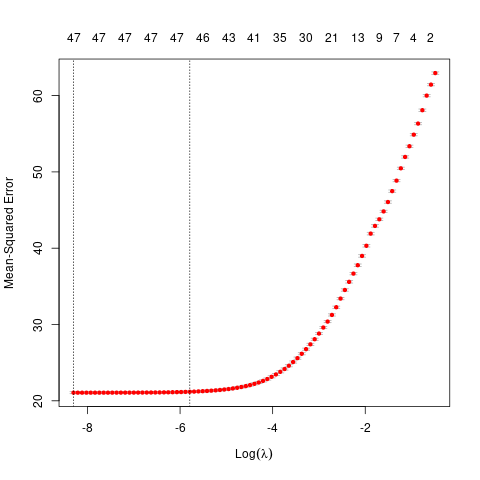

In [65]:
%%R
selected_gs <- pruneGenesets(data = x, genesetlist = HM_genesets, hvg = hvg,
                            embedding = y, min_gs_size = 3, lambda = exp(-4.5)) 

In [66]:
%%R
as.character(selected_gs)

 [1] "HALLMARK_TNFA_SIGNALING_VIA_NFKB"          
 [2] "HALLMARK_HYPOXIA"                          
 [3] "HALLMARK_CHOLESTEROL_HOMEOSTASIS"          
 [4] "HALLMARK_MITOTIC_SPINDLE"                  
 [5] "HALLMARK_IL6_JAK_STAT3_SIGNALING"          
 [6] "HALLMARK_G2M_CHECKPOINT"                   
 [7] "HALLMARK_APOPTOSIS"                        
 [8] "HALLMARK_ESTROGEN_RESPONSE_EARLY"          
 [9] "HALLMARK_ESTROGEN_RESPONSE_LATE"           
[10] "HALLMARK_ANDROGEN_RESPONSE"                
[11] "HALLMARK_MYOGENESIS"                       
[12] "HALLMARK_PROTEIN_SECRETION"                
[13] "HALLMARK_INTERFERON_ALPHA_RESPONSE"        
[14] "HALLMARK_INTERFERON_GAMMA_RESPONSE"        
[15] "HALLMARK_APICAL_JUNCTION"                  
[16] "HALLMARK_APICAL_SURFACE"                   
[17] "HALLMARK_HEDGEHOG_SIGNALING"               
[18] "HALLMARK_COMPLEMENT"                       
[19] "HALLMARK_PI3K_AKT_MTOR_SIGNALING"          
[20] "HALLMARK_MTORC1_SIGNALING"                 


In [67]:
%%R 

target <- genesets2ids(x[match(hvg, rownames(x)),], HM_genesets[selected_gs])

dim(x)
dim(target)



ann_res <- scDECAF(data = x, gs = target, standardize = FALSE, 
                   hvg = hvg, k = 20, embedding = y,
                   n_components = ncol(target) - 1, max_iter = 2, thresh = 0.5)


R[write to console]: Learning geneset representations by CCA using 39 dimensions...




 Permutation  1  out of  10  12345678910
 Permutation  2  out of  10  12345678910
 Permutation  3  out of  10  12345678910
 Permutation  4  out of  10  12345678910
 Permutation  5  out of  10  12345678910
 Permutation  6  out of  10  12345678910
 Permutation  7  out of  10  12345678910
 Permutation  8  out of  10  12345678910
 Permutation  9  out of  10  12345678910
 Permutation  10  out of  10  12345678910
123456
123456789101112
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112

R[write to console]: Assigning cells to genesets in latent space...

R[write to console]: Verifying assignments by weighted k-nn...

R[write to console]: using 20 nearest neighbors and confidence threshold 0.5

R[write to console]: cell-geneset assignment completed.



In [68]:
%%R
scores = attributes(ann_res)$raw_scores
dim(scores)

[1] 57669    40


In [69]:
%%R -o scores
scores = data.frame(scores)

In [70]:
umap_adata.obs_names = np.concatenate((query.obs_names.values, adata.obs_names.values))

In [71]:
umap_adata.obs = pd.concat((obsdata, scores, query.obs.Resp, query.obs.Gender), axis = 1)

In [72]:
%%R -o selected_gs_

selected_gs_ = data.frame(pathway = as.character(selected_gs))

In [73]:
selected_gs_ = selected_gs_.iloc[:,0].tolist()

In [74]:
selected_gs_

['HALLMARK_TNFA_SIGNALING_VIA_NFKB',
 'HALLMARK_HYPOXIA',
 'HALLMARK_CHOLESTEROL_HOMEOSTASIS',
 'HALLMARK_MITOTIC_SPINDLE',
 'HALLMARK_IL6_JAK_STAT3_SIGNALING',
 'HALLMARK_G2M_CHECKPOINT',
 'HALLMARK_APOPTOSIS',
 'HALLMARK_ESTROGEN_RESPONSE_EARLY',
 'HALLMARK_ESTROGEN_RESPONSE_LATE',
 'HALLMARK_ANDROGEN_RESPONSE',
 'HALLMARK_MYOGENESIS',
 'HALLMARK_PROTEIN_SECRETION',
 'HALLMARK_INTERFERON_ALPHA_RESPONSE',
 'HALLMARK_INTERFERON_GAMMA_RESPONSE',
 'HALLMARK_APICAL_JUNCTION',
 'HALLMARK_APICAL_SURFACE',
 'HALLMARK_HEDGEHOG_SIGNALING',
 'HALLMARK_COMPLEMENT',
 'HALLMARK_PI3K_AKT_MTOR_SIGNALING',
 'HALLMARK_MTORC1_SIGNALING',
 'HALLMARK_E2F_TARGETS',
 'HALLMARK_MYC_TARGETS_V1',
 'HALLMARK_MYC_TARGETS_V2',
 'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION',
 'HALLMARK_INFLAMMATORY_RESPONSE',
 'HALLMARK_XENOBIOTIC_METABOLISM',
 'HALLMARK_FATTY_ACID_METABOLISM',
 'HALLMARK_GLYCOLYSIS',
 'HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY',
 'HALLMARK_P53_PATHWAY',
 'HALLMARK_UV_RESPONSE_UP',
 'HALLMARK_ANGIO

In [75]:
import matplotlib as mpl

# not shown because of notebook size ----

# sc.pl.umap(
#     umap_adata, 
#     color= selected_gs_, 
#     frameon=False,
#     wspace = 0.75,
#     ncols=2,
# #     vmin = -2,
# #     vmax = 2,
#     color_map=mpl.cm.RdBu_r, # RdYlBu
#     save = '_pbmc_covid_scDECAF_lambda_negative4pt5.png'
# )

In [76]:
mdata = umap_adata.obs

In [77]:
%%R -o selected_gs
genesets <- list(as.character(selected_gs))

In [78]:
selected_gs

'HALLMARK...,'HALLMARK...,'HALLMARK...,...,'HALLMARK...,'HALLMARK...,'HALLMARK...


In [79]:
genesets = list(np.array(selected_gs))

In [80]:
genesets = selected_gs_

In [81]:
len(genesets)

40

In [82]:
umap_adata.obs.drop(umap_adata.obs.columns[[23]], axis=1, inplace=True)

In [83]:
umap_adata.obs = umap_adata.obs.loc[:,~umap_adata.obs.columns.duplicated()]

In [84]:
umap_adata.obs['Resp'] = None
umap_adata.obs['Resp'][umap_adata.obs.dataset.isin(['query'])] = query.obs.Resp.values

/tmp/ipykernel_51890/817180651.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  umap_adata.obs['Resp'] = None
/tmp/ipykernel_51890/817180651.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  umap_adata.obs['Resp'][umap_adata.obs.dataset.isin(['query'])] = query.obs.Resp.values
/tmp/ipykernel_51890/817180651.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  umap_adata.obs['

In [85]:
umap_adata.obs['Resp'] = umap_adata.obs['Resp'].astype('category')

/tmp/ipykernel_51890/351891797.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  umap_adata.obs['Resp'] = umap_adata.obs['Resp'].astype('category')


In [86]:
umap_adata

AnnData object with n_obs × n_vars = 209763 × 2
    obs: 'celltype', 'dataset', 'Resp', 'HALLMARK_TNFA_SIGNALING_VIA_NFKB', 'HALLMARK_HYPOXIA', 'HALLMARK_CHOLESTEROL_HOMEOSTASIS', 'HALLMARK_MITOTIC_SPINDLE', 'HALLMARK_IL6_JAK_STAT3_SIGNALING', 'HALLMARK_G2M_CHECKPOINT', 'HALLMARK_APOPTOSIS', 'HALLMARK_ESTROGEN_RESPONSE_EARLY', 'HALLMARK_ESTROGEN_RESPONSE_LATE', 'HALLMARK_ANDROGEN_RESPONSE', 'HALLMARK_MYOGENESIS', 'HALLMARK_PROTEIN_SECRETION', 'HALLMARK_INTERFERON_ALPHA_RESPONSE', 'HALLMARK_INTERFERON_GAMMA_RESPONSE', 'HALLMARK_APICAL_JUNCTION', 'HALLMARK_APICAL_SURFACE', 'HALLMARK_HEDGEHOG_SIGNALING', 'HALLMARK_COMPLEMENT', 'HALLMARK_PI3K_AKT_MTOR_SIGNALING', 'HALLMARK_MTORC1_SIGNALING', 'HALLMARK_MYC_TARGETS_V1', 'HALLMARK_MYC_TARGETS_V2', 'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION', 'HALLMARK_INFLAMMATORY_RESPONSE', 'HALLMARK_XENOBIOTIC_METABOLISM', 'HALLMARK_FATTY_ACID_METABOLISM', 'HALLMARK_GLYCOLYSIS', 'HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY', 'HALLMARK_P53_PATHWAY', 'HALLMARK_

In [87]:
umap_adata.obs.Resp.value_counts()

Healthy    29501
severe     16743
mod        11425
Name: Resp, dtype: int64

In [88]:
plotdata = umap_adata.obs
plotdata = plotdata[plotdata.dataset == 'query']
plotdata = plotdata[plotdata.Resp.isin(['Healthy','severe'])]
plotdata.Resp = plotdata.Resp.cat.remove_unused_categories()

In [89]:
plotdata = plotdata.drop(columns = ['dataset'])

In [90]:
plotdata.head()

,celltype,Resp,HALLMARK_TNFA_SIGNALING_VIA_NFKB,HALLMARK_HYPOXIA,HALLMARK_CHOLESTEROL_HOMEOSTASIS,HALLMARK_MITOTIC_SPINDLE,HALLMARK_IL6_JAK_STAT3_SIGNALING,HALLMARK_G2M_CHECKPOINT,HALLMARK_APOPTOSIS,HALLMARK_ESTROGEN_RESPONSE_EARLY,HALLMARK_ESTROGEN_RESPONSE_LATE,HALLMARK_ANDROGEN_RESPONSE,HALLMARK_MYOGENESIS,HALLMARK_PROTEIN_SECRETION,HALLMARK_INTERFERON_ALPHA_RESPONSE,HALLMARK_INTERFERON_GAMMA_RESPONSE,HALLMARK_APICAL_JUNCTION,HALLMARK_APICAL_SURFACE,HALLMARK_HEDGEHOG_SIGNALING,HALLMARK_COMPLEMENT,HALLMARK_PI3K_AKT_MTOR_SIGNALING,HALLMARK_MTORC1_SIGNALING,HALLMARK_MYC_TARGETS_V1,HALLMARK_MYC_TARGETS_V2,HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,HALLMARK_INFLAMMATORY_RESPONSE,HALLMARK_XENOBIOTIC_METABOLISM,HALLMARK_FATTY_ACID_METABOLISM,HALLMARK_GLYCOLYSIS,HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY,HALLMARK_P53_PATHWAY,HALLMARK_UV_RESPONSE_UP,HALLMARK_ANGIOGENESIS,HALLMARK_HEME_METABOLISM,HALLMARK_COAGULATION,HALLMARK_IL2_STAT5_SIGNALING,HALLMARK_BILE_ACID_METABOLISM,HALLMARK_PEROXISOME,HALLMARK_ALLOGRAFT_REJECTION,HALLMARK_SPERMATOGENESIS,HALLMARK_KRAS_SIGNALING_UP,Gender
AAACCCACACCAGCGT-1,Plasmablast,severe,-0.065606,-0.126435,0.124809,-0.040840,0.003975,0.314563,-0.004697,-0.081681,0.151583,0.024582,0.076935,0.097124,-0.027219,-0.068822,0.014604,-0.116381,0.005289,0.116731,0.029536,0.320263,0.275262,0.085113,0.113741,-0.032846,0.053228,0.146809,0.017515,0.127881,-0.078167,-0.079016,0.002807,-0.018420,0.097933,0.023284,-0.071850,0.119403,-0.069741,0.056704,-0.063688,F
AAACCCACATCTCAAG-1,NK,severe,0.017313,-0.108716,0.044677,0.133212,-0.057817,0.084977,-0.121413,0.265256,-0.021967,0.240601,-0.216495,0.105333,0.392072,0.048951,-0.112637,-0.036962,0.091515,-0.010783,-0.030107,-0.059506,-0.247968,-0.148585,-0.101895,-0.001676,0.081409,-0.071525,0.167743,-0.050830,0.069175,-0.021991,-0.180849,0.218540,0.012894,-0.351541,0.016544,-0.133204,0.030064,0.017817,-0.020475,F
AAACGAAAGACCTGGA-1,Plasmablast,severe,0.189169,0.096894,-0.049152,0.018251,0.139411,-0.092601,0.305205,-0.015771,0.170490,0.058611,-0.096226,0.318924,-0.122413,0.034459,-0.061808,-0.035559,-0.053178,-0.000399,0.435439,0.620162,-0.043802,0.001566,0.223150,-0.007335,0.089864,0.015816,0.218956,0.049604,0.086510,0.046234,-0.048831,0.084948,0.024322,0.020927,0.081617,-0.017271,-0.138960,0.029243,0.061189,F
AAACGCTCAGTGGGTA-1,NK,severe,0.298116,0.458089,0.167981,-0.112442,-0.138111,-0.141571,-0.074616,-0.134465,0.153617,0.159038,-0.061775,0.054131,-0.059823,0.305424,0.020894,0.070266,0.092216,-0.038821,0.109486,0.031792,0.174034,0.276510,-0.152917,0.078601,-0.103494,0.042601,-0.250843,-0.233543,-0.105024,0.151570,-0.043811,-0.038671,-0.144290,0.074373,0.127744,0.024067,0.271972,0.013880,0.036362,F
AAACGCTGTAGCTTGT-1,B memory,severe,0.295947,-0.065996,-0.041167,0.468989,0.366035,0.209026,0.126171,-0.034498,-0.098644,0.216077,0.271290,0.167193,-0.012988,0.263349,0.041272,0.048409,-0.099723,-0.164567,-0.127255,0.035128,0.037921,-0.146750,0.091778,-0.000777,-0.150332,-0.046675,0.225090,0.183674,0.136628,0.226447,-0.182133,-0.061962,-0.189619,0.219884,-0.106877,0.033891,0.025635,0.156838,-0.176817,F


In [91]:
%%R -i plotdata

score_data <- plotdata



ct_pathway_res <- list()
ct_pathway_stats <- list()
for (ct in unique(plotdata$celltype)){
#     print(ct)
    ct_score_data <- score_data[score_data$celltype == ct, ]
    group <- ct_score_data$Resp
    ct_pathway_pvals <- apply(ct_score_data[, grep("celltype|Resp|Gender", colnames(ct_score_data), invert=TRUE)],
                             2,
                             FUN = function(x) t.test(x[group == 'severe'], x[group == 'Healthy'])$p.value)
                              
    ct_pathway_stat <- apply(ct_score_data[, grep("celltype|Resp|Gender", colnames(ct_score_data), invert=TRUE)],
                             2,
                             FUN = function(x) t.test(x[group == 'severe'], x[group == 'Healthy'])$statistic) 
                              
    ct_pathway_res[[ct]] <- p.adjust(ct_pathway_pvals, method = 'BH')
    ct_pathway_stats[[ct]] <- ct_pathway_stat
 
    
}

                              
ct_pathway_pval_res <- do.call(cbind, ct_pathway_res)                              
ct_pathway_stats <- do.call(cbind, ct_pathway_stats)    
ct_stats <- ct_pathway_stats                             
# print(head(ct_pathway_pval_res))

In [92]:
%%R
print(table(ct_pathway_pval_res[,"NK Proliferating"] < 0.05))


FALSE  TRUE 
   36     3 


In [93]:
%%R
print(table(ct_pathway_pval_res < 0.05))


FALSE  TRUE 
  672   498 


In [94]:
%%R
print(dim(ct_pathway_pval_res))

[1] 39 30


In [95]:
%%R
print(dim(ct_stats))
print(dim(ct_pathway_pval_res))

[1] 39 30
[1] 39 30


In [96]:
%%R
print(head(rownames(ct_stats)))

[1] "HALLMARK_TNFA_SIGNALING_VIA_NFKB" "HALLMARK_HYPOXIA"                
[3] "HALLMARK_CHOLESTEROL_HOMEOSTASIS" "HALLMARK_MITOTIC_SPINDLE"        
[5] "HALLMARK_IL6_JAK_STAT3_SIGNALING" "HALLMARK_G2M_CHECKPOINT"         


In [97]:
%%R
#better visualisation to identify MCPs, for example
 # FDR
keep <- (ct_pathway_pval_res < 0.05)

# set T-stats to zero for insignificant hints
ct_stats[!keep] <- 0
# drop all-zero rows and columns
keep_col <- colSums(ct_stats!=0) > 0
ct_stats <- ct_stats[rowSums(ct_stats != 0) > 0, keep_col] 
ct_stats <- scale(ct_stats) # monocyte stats are very large - normalise per cell type
print(dim(ct_stats))


ord_pathways <- hclust( dist(ct_stats, method = "euclidean"), method = "ward.D")$order
print(length(ord_pathways))

ord_celltypes <- hclust( dist(t(ct_stats), method = "euclidean"), method = "ward.D")$order
print(length(ord_celltypes))

[1] 39 26
[1] 39
[1] 26


In [98]:
%%R
ct_stats <- ct_stats[ord_pathways, ord_celltypes]

ct_pathway_stats <- data.frame(ct_stats)
ct_pathway_stats$pathway <- rownames(ct_pathway_stats)
ct_pathway_stats <- reshape2::melt(ct_pathway_stats)
ct_pathway_stats$id <- paste(ct_pathway_stats$pathway, ct_pathway_stats$variable, sep = "_")

# add FDR vals ----
fdr_vals <- ct_pathway_pval_res
fdr_vals <- data.frame(fdr_vals)
fdr_vals$pathway <- rownames(fdr_vals)
fdr_vals <- reshape2::melt(fdr_vals)
fdr_vals$id <- paste(fdr_vals$pathway, fdr_vals$variable, sep = "_")
fdr_vals <- fdr_vals[match(ct_pathway_stats$id, fdr_vals$id),]

## FDR is applied per cell type 
ct_pathway_stats$FDR <- fdr_vals$value
ct_pathway_stats$signif <- cut(ct_pathway_stats$value, breaks=c(-Inf, 0.001, 0.01, 0.05, Inf), label=c("***", "**", "*", ""))

# print(head(ct_pathway_stats))

R[write to console]: Using pathway as id variables

R[write to console]: Using pathway as id variables



In [99]:
%%R
print(head(colnames(ct_stats)))

[1] "Plasmablast"      "HSPC"             "CD8 TCM"          "NK Proliferating"
[5] "NK_CD56bright"    "CD4 CTL"         


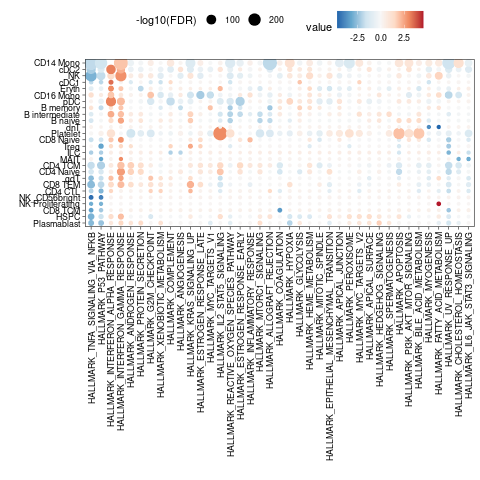

In [100]:
%%R

# note need to explicitly incorporate hclust results 

ct_pathway_stats$pathway <- factor(ct_pathway_stats$pathway, levels = rownames(ct_stats))
ct_pathway_stats$variable <- gsub("\\."," ", ct_pathway_stats$variable)
ct_pathway_stats$variable <- factor(ct_pathway_stats$variable, levels = colnames(ct_stats))


ggplot(ct_pathway_stats, aes(y=pathway, x = variable)) +
    geom_point(aes(size = -log10(FDR), color = value)) +  
    scale_color_distiller(palette = 'RdBu') +
#     geom_text(aes(label = signif), size = 1.9, color = 'black') + 
    theme_linedraw() + 
    coord_flip() + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1, color='black'), legend.position="top", panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
    xlab('') + ylab('') + labs(fill = expression(-log[10]~FDR))
# ggsave("figures/heatmap_HallmarkPathways_celltypes_COVIDseverityquery_alpha4pt5.png", units="in", width=8, height=8, dpi=200)

In [101]:
%%R -o final_genesets
final_genesets = rownames(ct_stats)

In [102]:
len(final_genesets)

39

In [103]:
final_genesets = list(final_genesets)
final_genesets

['HALLMARK_TNFA_SIGNALING_VIA_NFKB',
 'HALLMARK_P53_PATHWAY',
 'HALLMARK_INTERFERON_ALPHA_RESPONSE',
 'HALLMARK_INTERFERON_GAMMA_RESPONSE',
 'HALLMARK_ANDROGEN_RESPONSE',
 'HALLMARK_PROTEIN_SECRETION',
 'HALLMARK_G2M_CHECKPOINT',
 'HALLMARK_XENOBIOTIC_METABOLISM',
 'HALLMARK_COMPLEMENT',
 'HALLMARK_ANGIOGENESIS',
 'HALLMARK_KRAS_SIGNALING_UP',
 'HALLMARK_ESTROGEN_RESPONSE_LATE',
 'HALLMARK_MYC_TARGETS_V1',
 'HALLMARK_IL2_STAT5_SIGNALING',
 'HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY',
 'HALLMARK_ESTROGEN_RESPONSE_EARLY',
 'HALLMARK_INFLAMMATORY_RESPONSE',
 'HALLMARK_MTORC1_SIGNALING',
 'HALLMARK_ALLOGRAFT_REJECTION',
 'HALLMARK_COAGULATION',
 'HALLMARK_HYPOXIA',
 'HALLMARK_GLYCOLYSIS',
 'HALLMARK_HEME_METABOLISM',
 'HALLMARK_MITOTIC_SPINDLE',
 'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION',
 'HALLMARK_APICAL_JUNCTION',
 'HALLMARK_PEROXISOME',
 'HALLMARK_MYC_TARGETS_V2',
 'HALLMARK_APICAL_SURFACE',
 'HALLMARK_HEDGEHOG_SIGNALING',
 'HALLMARK_SPERMATOGENESIS',
 'HALLMARK_APOPTOSIS',
 'HALLMAR

In [104]:
plotdata = pd.melt(plotdata, id_vars= ['celltype','Resp'], value_vars=final_genesets)

In [105]:
plotdata.Resp = plotdata.Resp.astype('category')

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt

In [107]:
plotdata.head()

,celltype,Resp,variable,value
0,Plasmablast,severe,HALLMARK_TNFA_SIGNALING_VIA_NFKB,-0.065606
1,NK,severe,HALLMARK_TNFA_SIGNALING_VIA_NFKB,0.017313
2,Plasmablast,severe,HALLMARK_TNFA_SIGNALING_VIA_NFKB,0.189169
3,NK,severe,HALLMARK_TNFA_SIGNALING_VIA_NFKB,0.298116
4,B memory,severe,HALLMARK_TNFA_SIGNALING_VIA_NFKB,0.295947


In [108]:
%%R -o cd4_pathways
cd4_pathways <- ct_pathway_stats$pathway[abs(ct_pathway_stats$value) > 0.8 & ct_pathway_stats$variable %in% 'CD4 Naive']

In [109]:
len(list(cd4_pathways))

16

In [110]:
# list(cd4_pathways)

In [111]:
# set(plotdata.celltype)

In [112]:
cd4_pathways = list(cd4_pathways)

/tmp/ipykernel_51890/2860102893.py:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


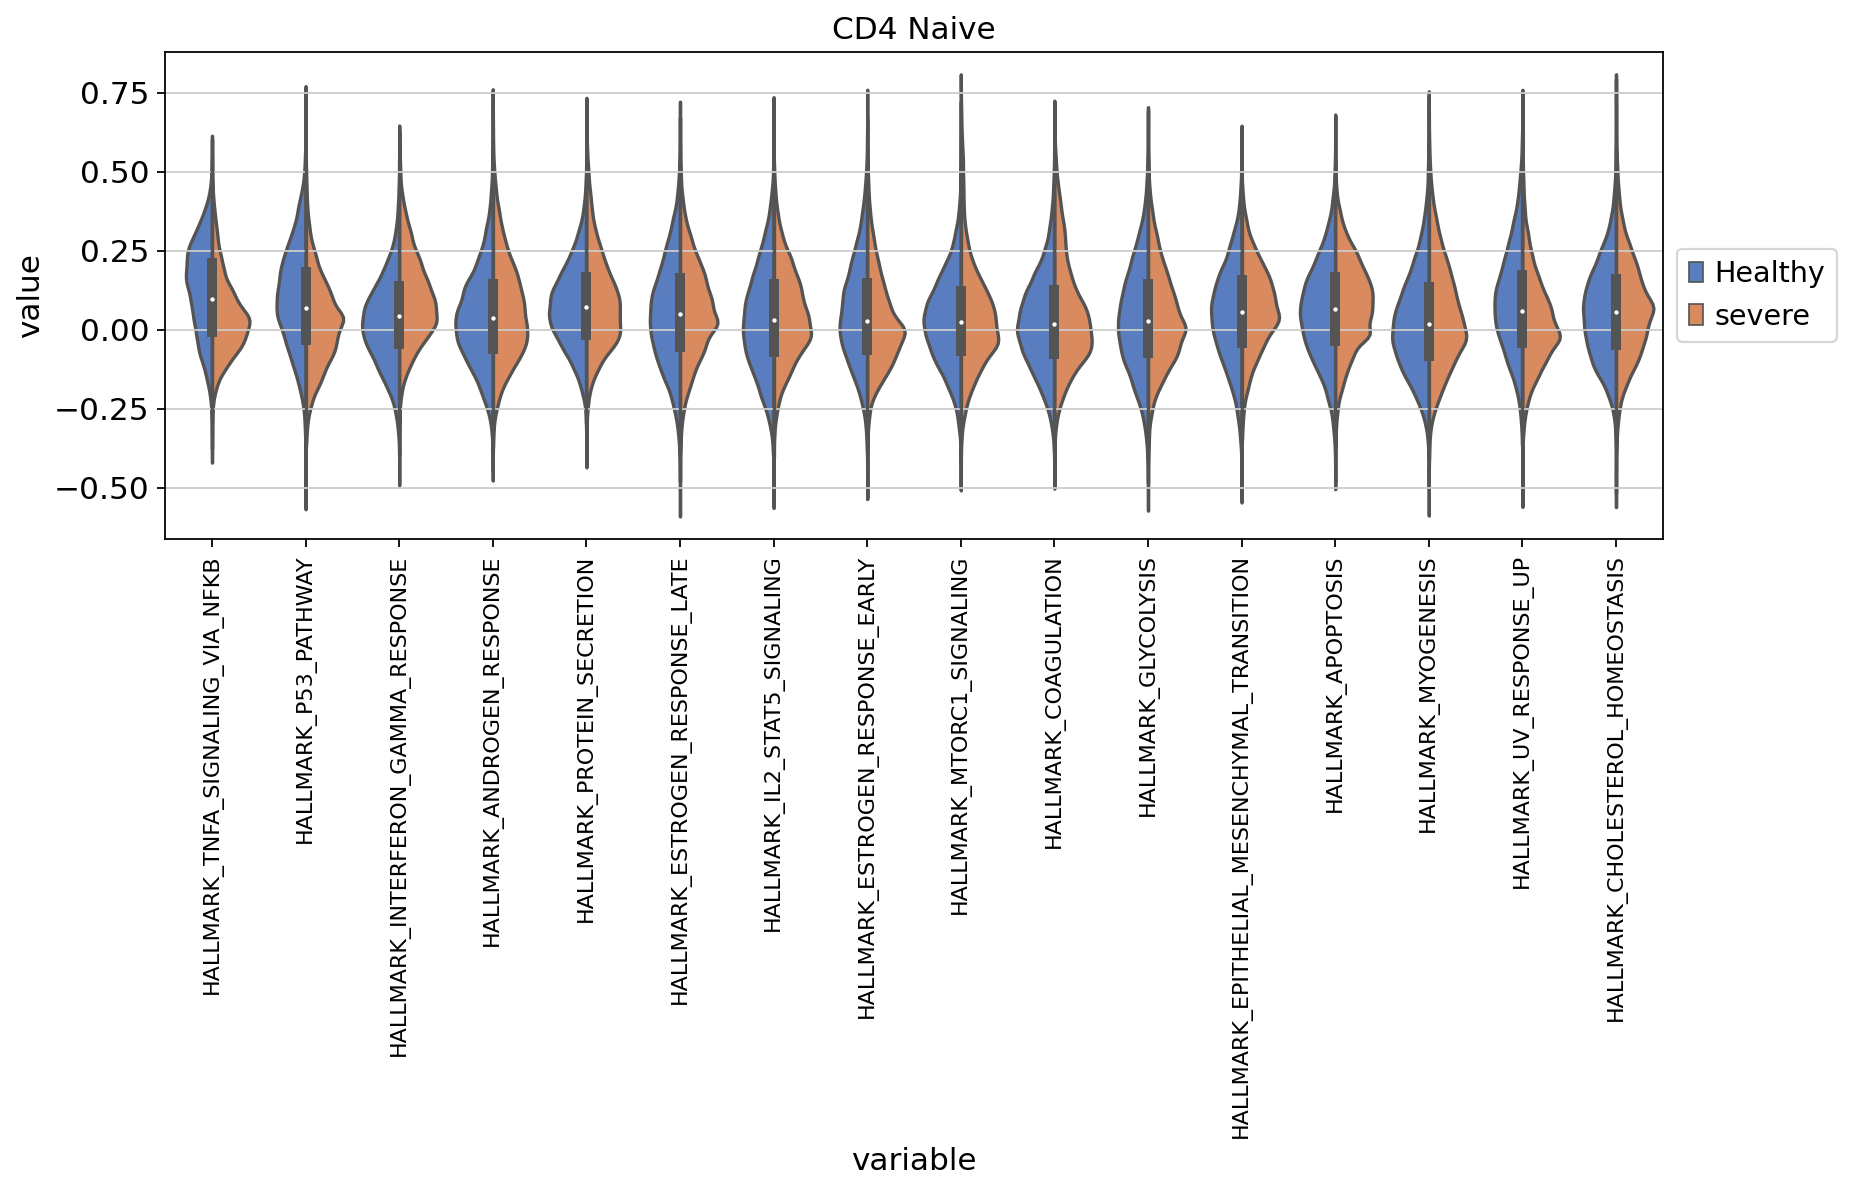

In [113]:
for cell_type in ['CD4 Naive']:
    fig = plt.figure(figsize=(12, 4))
    splotdata = plotdata[plotdata.celltype == cell_type]
    splotdata = plotdata[plotdata.variable.isin(cd4_pathways)]
    
    ax = sns.violinplot(x="variable", y="value", hue="Resp",
                        data=splotdata, palette="muted", split=True)
    ax.set_title(cell_type)
    plt.xticks(rotation=90, fontsize =10)
    fig.canvas.draw()
    fig.tight_layout()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     fig.savefig(f'figures/violin_celltype_{cell_type}.png', bbox_inches='tight')

## Milo

In [114]:
query = sc.read('data/totalVI_cite_pbmc_query.h5ad')
query

AnnData object with n_obs × n_vars = 57669 × 4000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.4', 'seurat_clusters', 'set', 'Resp', 'disease', 'subj_code', 'covidpt_orhealth', 'mito', 'ncount', 'nfeat', 'bust_21', 'og_clust', 'severmod_other', 'og_clusts', 'nCount_ADT', 'nFeature_ADT', 'UMAP1', 'UMAP2', 'final_clust', 'final_clust_v2', 'new_pt_id', 'Resp_og', 'final_clust_withnum', 'final_clust_review', 'Age', 'Gender', 'Gender_num', 'doublet_scores', 'predicted_doublets', 'celltype.l2', 'dataset_name', '_scvi_labels', '_scvi_batch', 'predicted_l2_scarches'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltype.l2_colors', 'final_clust_review_colors', 'log1p'
    obsm: 'X_totalvi_scarches', 'X_umap', 'X_umap_project', 'pro_exp', 'protein_counts'
    layers: 'counts'

In [115]:
X_totalvi_scarches = query.obsm['X_totalvi_scarches']
X_umap = query.obsm['X_umap'].to_numpy() 

In [116]:
del query.obsm

In [117]:
# del query.uns

In [118]:
# del query.layers

In [119]:
#  query.obsm.keys()

In [120]:
umap_adata

AnnData object with n_obs × n_vars = 209763 × 2
    obs: 'celltype', 'dataset', 'Resp', 'HALLMARK_TNFA_SIGNALING_VIA_NFKB', 'HALLMARK_HYPOXIA', 'HALLMARK_CHOLESTEROL_HOMEOSTASIS', 'HALLMARK_MITOTIC_SPINDLE', 'HALLMARK_IL6_JAK_STAT3_SIGNALING', 'HALLMARK_G2M_CHECKPOINT', 'HALLMARK_APOPTOSIS', 'HALLMARK_ESTROGEN_RESPONSE_EARLY', 'HALLMARK_ESTROGEN_RESPONSE_LATE', 'HALLMARK_ANDROGEN_RESPONSE', 'HALLMARK_MYOGENESIS', 'HALLMARK_PROTEIN_SECRETION', 'HALLMARK_INTERFERON_ALPHA_RESPONSE', 'HALLMARK_INTERFERON_GAMMA_RESPONSE', 'HALLMARK_APICAL_JUNCTION', 'HALLMARK_APICAL_SURFACE', 'HALLMARK_HEDGEHOG_SIGNALING', 'HALLMARK_COMPLEMENT', 'HALLMARK_PI3K_AKT_MTOR_SIGNALING', 'HALLMARK_MTORC1_SIGNALING', 'HALLMARK_MYC_TARGETS_V1', 'HALLMARK_MYC_TARGETS_V2', 'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION', 'HALLMARK_INFLAMMATORY_RESPONSE', 'HALLMARK_XENOBIOTIC_METABOLISM', 'HALLMARK_FATTY_ACID_METABOLISM', 'HALLMARK_GLYCOLYSIS', 'HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY', 'HALLMARK_P53_PATHWAY', 'HALLMARK_

In [121]:
umap_adata.obsm['X_umap']

array([[11.620995  ,  9.66514   ],
       [ 4.6916227 ,  0.10161626],
       [12.012509  ,  8.594099  ],
       ...,
       [ 5.013106  , 10.860527  ],
       [10.699944  ,  1.4571172 ],
       [10.700969  , -0.51655006]], dtype=float32)

In [122]:
query.obsm['X_umap'] = umap_adata[umap_adata.obs.dataset.isin(['query'])].obsm['X_umap']

In [123]:
query.obs['days_from_onset'] = query.obs.new_pt_id.map(mdata_dict['Day'])

In [124]:
%%R -i query
query

/home/users/allstaff/hediyehzadeh.s/.local/lib/python3.9/site-packages/anndata2ri/r2py.py:102: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(exprs, obs, var, uns, obsm or None, layers=layers)
/home/users/allstaff/hediyehzadeh.s/.local/lib/python3.9/site-packages/anndata2ri/r2py.py:102: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(exprs, obs, var, uns, obsm or None, layers=layers)


class: SingleCellExperiment 
dim: 4000 57669 
metadata(5): _scvi_manager_uuid _scvi_uuid celltype.l2_colors
  final_clust_review_colors log1p
assays(2): X counts
rownames(4000): AL645608.8 HES4 ... TMEM98 Z82244.2
rowData names(0):
colnames(57669): AAACCCACACCAGCGT-1 AAACCCACATCTCAAG-1 ...
  TTTGTTGCAGGCGATA-1 TTTGTTGTCTTCTGTA-1
colData names(38): orig.ident nCount_RNA ... predicted_l2_scarches
  days_from_onset
reducedDimNames(1): UMAP
mainExpName: NULL
altExpNames(0):


In [125]:
%%R
library(miloR)

In [126]:
%%R
dim(attributes(ann_res)$raw_scores)

[1] 57669    40


In [127]:
%%R
head(rownames(attributes(ann_res)$raw_scores))

[1] "AAACCCACACCAGCGT-1" "AAACCCACATCTCAAG-1" "AAACGAAAGACCTGGA-1"
[4] "AAACGCTCAGTGGGTA-1" "AAACGCTGTAGCTTGT-1" "AAACGCTGTTTGACAC-1"


In [128]:
%%R

# assign gene set scores as an assay
assay(query,'counts') <- assay(query,'X')
# assay(query,'scdecaf_gps') <- t(attributes(ann_res)$raw_scores)

In [129]:
%%R
print(dim(assay(query,'counts')))
print(dim(t(attributes(ann_res)$raw_scores)))

[1]  4000 57669
[1]    40 57669


In [130]:
%%R -o scdecaf_gps
scdecaf_gps <- attributes(ann_res)$raw_scores

In [131]:
%%R -o gp_names
gp_names <- colnames(attributes(ann_res)$raw_scores)

In [132]:
gp_adata = sc.AnnData(X=scdecaf_gps, obs = query.obs, obsm = query.obsm)
gp_adata.var_names = gp_names
gp_adata

/tmp/ipykernel_51890/3359315653.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  gp_adata = sc.AnnData(X=scdecaf_gps, obs = query.obs, obsm = query.obsm)


AnnData object with n_obs × n_vars = 57669 × 40
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.4', 'seurat_clusters', 'set', 'Resp', 'disease', 'subj_code', 'covidpt_orhealth', 'mito', 'ncount', 'nfeat', 'bust_21', 'og_clust', 'severmod_other', 'og_clusts', 'nCount_ADT', 'nFeature_ADT', 'UMAP1', 'UMAP2', 'final_clust', 'final_clust_v2', 'new_pt_id', 'Resp_og', 'final_clust_withnum', 'final_clust_review', 'Age', 'Gender', 'Gender_num', 'doublet_scores', 'predicted_doublets', 'celltype.l2', 'dataset_name', '_scvi_labels', '_scvi_batch', 'predicted_l2_scarches', 'days_from_onset'
    obsm: 'X_umap'

In [133]:
%%R -i gp_adata
gp_adata

/home/users/allstaff/hediyehzadeh.s/.local/lib/python3.9/site-packages/anndata2ri/r2py.py:102: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(exprs, obs, var, uns, obsm or None, layers=layers)
/home/users/allstaff/hediyehzadeh.s/.local/lib/python3.9/site-packages/anndata2ri/r2py.py:102: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(exprs, obs, var, uns, obsm or None, layers=layers)


class: SingleCellExperiment 
dim: 40 57669 
metadata(0):
assays(1): X
rownames(40): HALLMARK_TNFA_SIGNALING_VIA_NFKB HALLMARK_HYPOXIA ...
  HALLMARK_SPERMATOGENESIS HALLMARK_KRAS_SIGNALING_UP
rowData names(0):
colnames(57669): AAACCCACACCAGCGT-1 AAACCCACATCTCAAG-1 ...
  TTTGTTGCAGGCGATA-1 TTTGTTGTCTTCTGTA-1
colData names(38): orig.ident nCount_RNA ... predicted_l2_scarches
  days_from_onset
reducedDimNames(1): UMAP
mainExpName: NULL
altExpNames(0):


In [134]:
%%R
assay(gp_adata,'logcounts') <- assay(gp_adata,'X')

In [135]:
%%R

milo <- Milo(gp_adata)
milo <- buildGraph(milo, k=30, d=2, reduced.dim="UMAP")
milo <- makeNhoods(milo, prop=0.05, k=30, d=2,refined=T, reduced_dims="UMAP")
milo <- buildNhoodGraph(milo)
milo <- calcNhoodDistance(milo, d=2, reduced.dim="UMAP")

R[write to console]: Constructing kNN graph with k:30

R[write to console]: Checking valid object



In [136]:
%%R
milo

class: Milo 
dim: 40 57669 
metadata(0):
assays(2): X logcounts
rownames(40): HALLMARK_TNFA_SIGNALING_VIA_NFKB HALLMARK_HYPOXIA ...
  HALLMARK_SPERMATOGENESIS HALLMARK_KRAS_SIGNALING_UP
rowData names(0):
colnames(57669): AAACCCACACCAGCGT-1 AAACCCACATCTCAAG-1 ...
  TTTGTTGCAGGCGATA-1 TTTGTTGTCTTCTGTA-1
colData names(38): orig.ident nCount_RNA ... predicted_l2_scarches
  days_from_onset
reducedDimNames(1): UMAP
mainExpName: NULL
altExpNames(0):
nhoods dimensions(2): 57669 2750
nhoodCounts dimensions(2): 1 1
nhoodDistances dimension(1): 2750
graph names(1): graph
nhoodIndex names(1): 2750
nhoodExpression dimension(2): 1 1
nhoodReducedDim names(0):
nhoodGraph names(1): nhoodGraph
nhoodAdjacency dimension(2): 2750 2750


In [137]:
%%R
head(colData(milo))

                   orig.ident nCount_RNA nFeature_RNA RNA_snn_res.0.4
AAACCCACACCAGCGT-1       set1      45410         5428              15
AAACCCACATCTCAAG-1       set1       1839         1032              12
AAACGAAAGACCTGGA-1       set1      10759         1855              13
AAACGCTCAGTGGGTA-1       set1       1114          609              12
AAACGCTGTAGCTTGT-1       set1       5966         1850               7
AAACGCTGTTTGACAC-1       set1      63097         5905              15
                   seurat_clusters  set   Resp  disease subj_code
AAACCCACACCAGCGT-1              15 set1 severe COVID-19 nCOV3EUHM
AAACCCACATCTCAAG-1              12 set1 severe COVID-19 nCOV3EUHM
AAACGAAAGACCTGGA-1              13 set1 severe COVID-19 nCOV3EUHM
AAACGCTCAGTGGGTA-1              12 set1 severe COVID-19 nCOV3EUHM
AAACGCTGTAGCTTGT-1               7 set1 severe COVID-19 nCOV3EUHM
AAACGCTGTTTGACAC-1              15 set1 severe COVID-19 nCOV3EUHM
                   covidpt_orhealth      mito nc

In [138]:
%%R
print(table(milo$subj_code, milo$Resp))

              
               Healthy  mod severe
  258             5794    0      0
  259             5003    0      0
  265             8889    0      0
  279             4559    0      0
  280             5256    0      0
  nCOV1EUHM          0 5254      0
  nCOV3EUHM          0    0   3564
  nCOV6EUHM          0    0   1934
  nCOV7EUHM          0 1744      0
  nCOV021EUHM        0    0   4010
  nCOV024EUHM        0    0   7235
  nCOV0029EUHM       0 4427      0


In [139]:
%%R 
mdata = data.frame(colData(milo))
# mdata$sample_id <- droplevels(mdata$sample_id)
milo <- countCells(milo, meta.data=mdata, samples="subj_code")

R[write to console]: Checking meta.data validity

R[write to console]: Counting cells in neighbourhoods



R[write to console]: Loading required package: viridisLite



Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


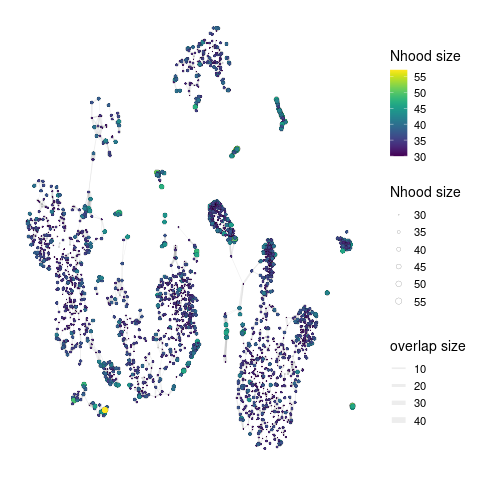

In [140]:
%%R
library(viridis)

plotNhoodGraph(milo, size_range=c(0.1,3), node_stroke=0.1) + 
scale_fill_viridis(name = "Nhood size", option = "viridis", direction = 1) 

In [141]:
%%R
library(dplyr)
sample_annot <- data.frame(colData(milo))[,c("subj_code", "Resp","orig.ident",'days_from_onset')]
sample_annot <- distinct(sample_annot)
rownames(sample_annot) <- sample_annot$subj_code
## Reorder rownames to match columns of nhoodCounts(milo)
sample_annot <- sample_annot[colnames(nhoodCounts(milo)), , drop=FALSE]



R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following object is masked from ‘package:Biobase’:

    combine


R[write to console]: The following objects are masked from ‘package:GenomicRanges’:

    intersect, setdiff, union


R[write to console]: The following object is masked from ‘package:GenomeInfoDb’:

    intersect


R[write to console]: The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union


R[write to console]: The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union


R[write to console]: The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union


R[write to console]: The following object is masked from ‘package:matrixStats’:

    count


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from

In [142]:
%%R
colnames(sample_annot) <- gsub("\\.","_", colnames(sample_annot))

In [143]:
%%R

head(sample_annot)

          subj_code    Resp orig_ident days_from_onset
258             258 Healthy       set2               –
259             259 Healthy       set1               –
265             265 Healthy       set2               –
279             279 Healthy       set1               –
280             280 Healthy       set1               –
nCOV1EUHM nCOV1EUHM     mod       set1               2


In [144]:
%%R
# design <- model.matrix(~orig_ident+Resp, data = sample_annot)
design <- model.matrix(~Resp, data = sample_annot)

print(head(design))

          (Intercept) Respmod Respsevere
258                 1       0          0
259                 1       0          0
265                 1       0          0
279                 1       0          0
280                 1       0          0
nCOV1EUHM           1       1          0


In [145]:
%%R
milo

class: Milo 
dim: 40 57669 
metadata(0):
assays(2): X logcounts
rownames(40): HALLMARK_TNFA_SIGNALING_VIA_NFKB HALLMARK_HYPOXIA ...
  HALLMARK_SPERMATOGENESIS HALLMARK_KRAS_SIGNALING_UP
rowData names(0):
colnames(57669): AAACCCACACCAGCGT-1 AAACCCACATCTCAAG-1 ...
  TTTGTTGCAGGCGATA-1 TTTGTTGTCTTCTGTA-1
colData names(38): orig.ident nCount_RNA ... predicted_l2_scarches
  days_from_onset
reducedDimNames(1): UMAP
mainExpName: NULL
altExpNames(0):
nhoods dimensions(2): 57669 2750
nhoodCounts dimensions(2): 2750 12
nhoodDistances dimension(1): 2750
graph names(1): graph
nhoodIndex names(1): 2750
nhoodExpression dimension(2): 1 1
nhoodReducedDim names(0):
nhoodGraph names(1): nhoodGraph
nhoodAdjacency dimension(2): 2750 2750


### Differential abundance and gene program activity: COVID Severe vs Healthy

In [146]:
%%R
da_results <- testNhoods(milo, design = design, 
                         design.df = sample_annot,
                         reduced.dim = 'UMAP',
                         model.contrasts = c('Respsevere')
                        ) 

R[write to console]: Using TMM normalisation

R[write to console]: Performing spatial FDR correction withk-distance weighting



Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


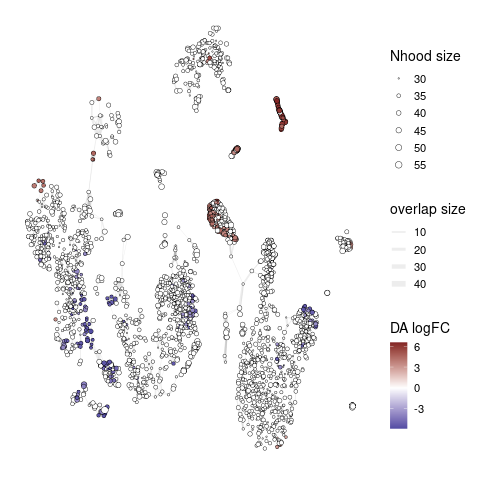

In [231]:
%%R
library(scales)
plotNhoodGraphDA(milo, da_results, alpha=0.05) + scale_fill_gradient2( low =  muted("blue"),
                                                                      mid = "white", 
                                                                      high = muted("red"), name="DA logFC")

In [232]:
%%R
ggsave("figures/umap_milograph_da_COVIDseverequery_alpha4pt5.png", units="in", width=8, height=6, dpi=200)

In [152]:
%%R
da_results <- annotateNhoods(milo, da_results, "predicted_l2_scarches")

In [153]:
%%R
print(dim(da_results))

[1] 2750    9


In [154]:
%%R
head(da_results)

       logFC   logCPM          F       PValue        FDR Nhood SpatialFDR
1 -2.3587996 9.056066  2.8332712 0.0923427297 0.26872223     1 0.17992153
2 -0.6425238 9.211607  0.3696039 0.5432258370 0.72470799     2 0.65622149
3  6.1158136 9.738657 11.9851753 0.0005371597 0.02840748     3 0.01057194
4 -1.8767897 9.209486  2.5095349 0.1131720972 0.30231669     4 0.21076671
5  4.7977965 9.393673 11.5047018 0.0006952896 0.02972896     5 0.01192392
6 -1.8031334 9.334518  2.1334690 0.1441269805 0.34315948     6 0.25029824
  predicted_l2_scarches predicted_l2_scarches_fraction
1                    NK                      0.9000000
2             CD14 Mono                      0.9696970
3           Plasmablast                      0.9361702
4               CD4 TCM                      1.0000000
5                 Eryth                      1.0000000
6               CD4 TCM                      0.6842105


In [155]:
%%R
# da_resutls <- groupNhoods(milo, da_results, da.fdr=0.01)

NULL


In [156]:
%%R
# head(da_results)

NULL


R[write to console]: Converting group.by to factor...



Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


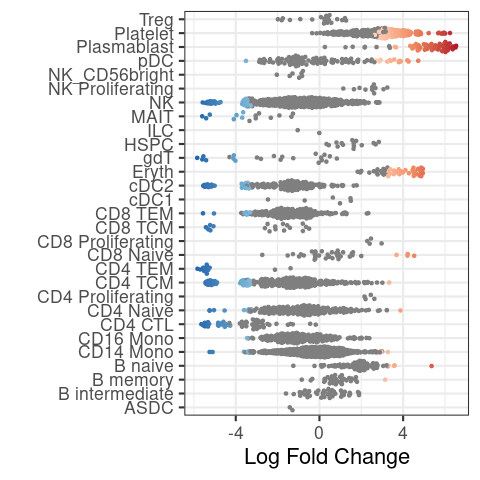

In [157]:
%%R
# for color consistency
plotDAbeeswarm(da_results, group.by = 'predicted_l2_scarches', alpha = 0.05) + xlab('') + scale_color_distiller(palette = 'RdBu') 


In [158]:
%%R
ggsave("figures/DAbeeswarm_COVIDseverequery_alpha4pt5.png", units="in", width=8, height=12, dpi=200)

In [159]:
%%R
# days of onset
da_results_onset <- annotateNhoods(milo, da_results, "days_from_onset")

R[write to console]: Converting days_from_onset to factor...



R[write to console]: Converting group.by to factor...



Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


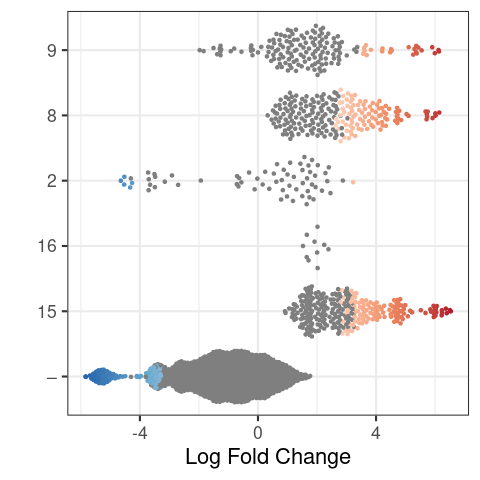

In [294]:
%%R
plotDAbeeswarm(da_results_onset, group.by = 'days_from_onset', alpha = 0.05) + xlab('') + scale_color_distiller(palette = 'RdBu') 


In [297]:
%%R
ggsave("figures/DAbeeswarm_COVIDseverequery_daysfromonset_alpha4pt5.png", units="in", width=5, height=6, dpi=200)

In [161]:
%%R
head(da_results_onset)

       logFC   logCPM          F       PValue        FDR Nhood SpatialFDR
1 -2.3587996 9.056066  2.8332712 0.0923427297 0.26872223     1 0.17992153
2 -0.6425238 9.211607  0.3696039 0.5432258370 0.72470799     2 0.65622149
3  6.1158136 9.738657 11.9851753 0.0005371597 0.02840748     3 0.01057194
4 -1.8767897 9.209486  2.5095349 0.1131720972 0.30231669     4 0.21076671
5  4.7977965 9.393673 11.5047018 0.0006952896 0.02972896     5 0.01192392
6 -1.8031334 9.334518  2.1334690 0.1441269805 0.34315948     6 0.25029824
  predicted_l2_scarches predicted_l2_scarches_fraction days_from_onset
1                    NK                      0.9000000               –
2             CD14 Mono                      0.9696970               –
3           Plasmablast                      0.9361702               9
4               CD4 TCM                      1.0000000               –
5                 Eryth                      1.0000000              15
6               CD4 TCM                      0.6842105  

In [162]:
%%R
da_results_onset_posFC <- da_results_onset[da_results_onset$logFC > 0 & da_results_onset$FDR < 0.05,]
print(table(da_results_onset_posFC$predicted_l2_scarches, da_results_onset_posFC$days_from_onset))

             
              15  8  9
  B naive      0  0  1
  CD8 Naive    0  0  1
  Eryth        9  0  0
  pDC          0  6  0
  Plasmablast 26 10 13
  Platelet    37 45  0


In [163]:
%%R
head(da_results)

       logFC   logCPM          F       PValue        FDR Nhood SpatialFDR
1 -2.3587996 9.056066  2.8332712 0.0923427297 0.26872223     1 0.17992153
2 -0.6425238 9.211607  0.3696039 0.5432258370 0.72470799     2 0.65622149
3  6.1158136 9.738657 11.9851753 0.0005371597 0.02840748     3 0.01057194
4 -1.8767897 9.209486  2.5095349 0.1131720972 0.30231669     4 0.21076671
5  4.7977965 9.393673 11.5047018 0.0006952896 0.02972896     5 0.01192392
6 -1.8031334 9.334518  2.1334690 0.1441269805 0.34315948     6 0.25029824
  predicted_l2_scarches predicted_l2_scarches_fraction
1                    NK                      0.9000000
2             CD14 Mono                      0.9696970
3           Plasmablast                      0.9361702
4               CD4 TCM                      1.0000000
5                 Eryth                      1.0000000
6               CD4 TCM                      0.6842105


In [164]:
%%R
print(dim(da_results))

[1] 2750    9


In [165]:
%%R
print(table(da_results$SpatialFDR < 0.05))


FALSE  TRUE 
 2312   438 


In [166]:
%%R
print(head(rownames(da_results)))

[1] "1" "2" "3" "4" "5" "6"


#### differential gene program activity by nhood

In [167]:
%%R
# head(mdata)
print(table(da_results$predicted_l2_scarches))


             ASDC    B intermediate          B memory           B naive 
                2                41                33                96 
        CD14 Mono         CD16 Mono           CD4 CTL         CD4 Naive 
              504               198                56               180 
CD4 Proliferating           CD4 TCM           CD4 TEM         CD8 Naive 
                4               275                13                36 
CD8 Proliferating           CD8 TCM           CD8 TEM              cDC1 
                4                18               171                 6 
             cDC2             Eryth               gdT              HSPC 
              159                43                22                15 
              ILC              MAIT                NK  NK Proliferating 
                2                15               390                11 
    NK_CD56bright               pDC       Plasmablast          Platelet 
                7               101               

In [168]:
%%R
# unique(da.res$NhoodGroup[da.res$predicted_l2_scarches %in% 
#                                                            c('NK')])

NULL


In [169]:
%%R
# as.numeric(unique(da.res$NhoodGroup[da.res$predicted_l2_scarches %in% 
#                                                            c('NK')]))

NULL


In [170]:
%%R
print(head(model.matrix(~orig.ident+Resp, mdata)))

                   (Intercept) orig.identset2 Respmod Respsevere
AAACCCACACCAGCGT-1           1              0       0          1
AAACCCACATCTCAAG-1           1              0       0          1
AAACGAAAGACCTGGA-1           1              0       0          1
AAACGCTCAGTGGGTA-1           1              0       0          1
AAACGCTGTAGCTTGT-1           1              0       0          1
AAACGCTGTTTGACAC-1           1              0       0          1


In [171]:
%%R
head(as.numeric(unique(da_results$Nhood[da_results$predicted_l2_scarches %in% 
                                                           c('NK')])))

[1]  1 10 17 21 36 40


In [172]:
%%R
da.res <- groupNhoods(milo, da_results, da.fdr=0.05)

R[write to console]: Found 438 DA neighbourhoods at FDR 5%

R[write to console]: nhoodAdjacency found - using for nhood grouping



In [173]:
%%R
max(as.numeric(da.res$NhoodGroup))

[1] 113


In [174]:
%%R
tail(da.res)

          logFC   logCPM         F     PValue       FDR Nhood SpatialFDR
2745  0.3831109 9.341217 0.1007225 0.75096696 0.8578988  2745 0.82245667
2746 -1.8903171 9.106506 2.4029756 0.12111749 0.3136281  2746 0.22131423
2747 -0.9417933 9.455533 0.5284446 0.46726839 0.6686532  2747 0.58989717
2748 -0.5388456 9.235823 0.2383046 0.62543762 0.7793426  2748 0.72068938
2749 -2.6382053 9.124082 4.1169220 0.04246694 0.1713957  2749 0.09994989
2750 -1.7168819 9.149992 2.2190407 0.13633048 0.3329159  2750 0.24006409
     predicted_l2_scarches predicted_l2_scarches_fraction NhoodGroup
2745                    NK                      0.6470588         61
2746                    NK                      0.9677419         10
2747        B intermediate                      0.6250000         47
2748               CD4 TCM                      0.9677419         62
2749               CD4 TCM                      1.0000000          4
2750             CD16 Mono                      0.9428571         53


In [175]:
%%R
head(as.numeric(unique(da.res$NhoodGroup[da.res$predicted_l2_scarches %in% 
                                                           c('CD4 Naive')])))

[1]  9 22 25 37 63 75


In [176]:
%%R
# print(table(da.res$NhoodGroup, da.res$predicted_l2_scarches))

NULL


In [177]:
%%R
head(da.res)

       logFC   logCPM          F       PValue        FDR Nhood SpatialFDR
1 -2.3587996 9.056066  2.8332712 0.0923427297 0.26872223     1 0.17992153
2 -0.6425238 9.211607  0.3696039 0.5432258370 0.72470799     2 0.65622149
3  6.1158136 9.738657 11.9851753 0.0005371597 0.02840748     3 0.01057194
4 -1.8767897 9.209486  2.5095349 0.1131720972 0.30231669     4 0.21076671
5  4.7977965 9.393673 11.5047018 0.0006952896 0.02972896     5 0.01192392
6 -1.8031334 9.334518  2.1334690 0.1441269805 0.34315948     6 0.25029824
  predicted_l2_scarches predicted_l2_scarches_fraction NhoodGroup
1                    NK                      0.9000000          1
2             CD14 Mono                      0.9696970          2
3           Plasmablast                      0.9361702          3
4               CD4 TCM                      1.0000000          4
5                 Eryth                      1.0000000          5
6               CD4 TCM                      0.6842105          6


In [178]:
%%R
colnames(mdata) <- gsub("\\.","_", colnames(mdata))

In [179]:
%%R
print(head(model.matrix(~orig_ident+Resp, data = mdata)))

                   (Intercept) orig_identset2 Respmod Respsevere
AAACCCACACCAGCGT-1           1              0       0          1
AAACCCACATCTCAAG-1           1              0       0          1
AAACGAAAGACCTGGA-1           1              0       0          1
AAACGCTCAGTGGGTA-1           1              0       0          1
AAACGCTGTAGCTTGT-1           1              0       0          1
AAACGCTGTTTGACAC-1           1              0       0          1


In [180]:
# %%R
# nhood.dge <- testDiffExp(milo, da.res, 
# #                          subset.nhoods = as.numeric(unique(da.res$Nhood[da.res$predicted_l2_scarches %in% 
# #                                                            c('Plasmablast')])),
#                          design=~orig_ident+Resp , meta.data=mdata,  
#                          n.coef = 4,
# #                          model.contrasts = c('Respsevere - RespHealthy'),
#                          assay = "logcounts"
#                         )
# nhood.dge

In [181]:
%%R
nhood.dge <- testDiffExp(milo, da.res, 
#                          subset.nhoods = as.numeric(unique(da.res$Nhood[da.res$predicted_l2_scarches %in% 
#                                                            c('Plasmablast')])),
                         design=~Resp , meta.data=mdata,  
                         n.coef = 3,
#                          model.contrasts = c('Respsevere - RespHealthy'),
                         assay = "logcounts"
                        )
# nhood.dge

Coefficients not estimable: Respmod 
Coefficients not estimable: Respmod 
Coefficients not estimable: Respsevere 


In [182]:
# %%R
# names(nhood.dge)

In [183]:
%%R
saveRDS(nhood.dge, file='differential_score_activity_nhoods_covidsevere.rds')

In [184]:
%%R
pernhood_dge <- do.call(rbind, nhood.dge)
pernhood_dge$pathway <- gsub('[0-9]+\\.','', rownames(pernhood_dge))
rownames(pernhood_dge) <- paste0("NhoodGroup", rownames(pernhood_dge))

In [185]:
%%R
# annotate nhood groups with cell types
nhoodgroup_ann <- table(da.res$predicted_l2_scarches, da.res$NhoodGroup)
nhoodgroup_ann <- apply(nhoodgroup_ann, 2, FUN=function(x) rownames(nhoodgroup_ann)[which.max(x)])
pernhood_dge$level_2 <- nhoodgroup_ann[pernhood_dge$Nhood.Group]

In [186]:
# %%R
# head(pernhood_dge)

In [187]:
%%R
# convert to one significance and logFC/statistic score per pathway/celltype
pernhood_dge$group <- paste(pernhood_dge$pathway, pernhood_dge$level_2, sep='_')
dfsplit <- split(pernhood_dge, pernhood_dge$group)


In [188]:
%%R
sum(lapply(dfsplit,FUN=function(x) nrow(x)) > 1)

[1] 640


In [189]:
%%R
# keep most significant changes
ggdat <- lapply(dfsplit,FUN=function(x) x[which.min(x$adj.P.Val),])

In [190]:
%%R
# ggdat[1:3]

NULL


In [191]:
%%R
ggdat <- do.call(rbind, ggdat)

In [192]:
# %%R
# tail(ggdat)

In [193]:
%%R
# make a matrix and run hclust
df <- ggdat[,c('pathway','level_2','t')]
df <- tidyr::spread(df, "pathway",'t')
rownames(df) <- df[,'level_2']
df$level_2 <- NULL

In [194]:
%%R
dim(df)

[1] 25 40


In [195]:
%%R
df_dist <- dist(t(df), method = 'euclidean')
hres <- hclust(df_dist)
head(hres$order)

[1] 24 25 32 38 39  1


In [196]:
%%R
length(hres$order)

[1] 40


In [197]:
%%R
# colnames(df)[hres$order]

NULL


In [198]:
%%R
df_dist2 <- dist(df, method = 'euclidean')
hres_ct <- hclust(df_dist2)

In [199]:
%%R
head(hres_ct$order)

[1] 24  5 15 22  6 17


In [200]:
%%R
ggdat$pathway <- factor(ggdat$pathway, levels = colnames(df)[hres$order])
ggdat$level_2 <- factor(ggdat$level_2, levels = rownames(df)[hres_ct$order])

In [220]:
%%R
ggdat$pathway <- gsub('_', ' ', ggdat$pathway)
head(ggdat)

                                                  logFC     AveExpr           t
HALLMARK_ALLOGRAFT_REJECTION_ASDC           -0.04876618  0.06330804  -1.0840273
HALLMARK_ALLOGRAFT_REJECTION_B intermediate -0.01946400  0.13002594  -0.9633454
HALLMARK_ALLOGRAFT_REJECTION_B memory       -0.06464353  0.08029930  -7.0347502
HALLMARK_ALLOGRAFT_REJECTION_B naive        -0.04218335  0.08351157  -3.8373417
HALLMARK_ALLOGRAFT_REJECTION_CD14 Mono      -0.14419772 -0.06569084 -14.7543553
HALLMARK_ALLOGRAFT_REJECTION_CD16 Mono      -0.03677060 -0.05695436  -3.3714965
                                                 P.Value    adj.P.Val
HALLMARK_ALLOGRAFT_REJECTION_ASDC           2.833324e-01 6.666644e-01
HALLMARK_ALLOGRAFT_REJECTION_B intermediate 3.367155e-01 5.180239e-01
HALLMARK_ALLOGRAFT_REJECTION_B memory       3.960397e-12 6.975393e-11
HALLMARK_ALLOGRAFT_REJECTION_B naive        1.393224e-04 8.723044e-04
HALLMARK_ALLOGRAFT_REJECTION_CD14 Mono      1.074510e-44 1.432680e-43
HALLMARK_ALLOGRAFT_R

In [280]:
%%R
ggdat$pathway <- as.factor(ggdat$pathway)
levels(ggdat$pathway)

 [1] "HALLMARK ALLOGRAFT REJECTION"              
 [2] "HALLMARK ANDROGEN RESPONSE"                
 [3] "HALLMARK ANGIOGENESIS"                     
 [4] "HALLMARK APICAL JUNCTION"                  
 [5] "HALLMARK APICAL SURFACE"                   
 [6] "HALLMARK APOPTOSIS"                        
 [7] "HALLMARK BILE ACID METABOLISM"             
 [8] "HALLMARK CHOLESTEROL HOMEOSTASIS"          
 [9] "HALLMARK COAGULATION"                      
[10] "HALLMARK COMPLEMENT"                       
[11] "HALLMARK E2F TARGETS"                      
[12] "HALLMARK EPITHELIAL MESENCHYMAL TRANSITION"
[13] "HALLMARK ESTROGEN RESPONSE EARLY"          
[14] "HALLMARK ESTROGEN RESPONSE LATE"           
[15] "HALLMARK FATTY ACID METABOLISM"            
[16] "HALLMARK G2M CHECKPOINT"                   
[17] "HALLMARK GLYCOLYSIS"                       
[18] "HALLMARK HEDGEHOG SIGNALING"               
[19] "HALLMARK HEME METABOLISM"                  
[20] "HALLMARK HYPOXIA"                          


In [281]:
%%R
bold.pathways <- c("HALLMARK TNFA SIGNALING VIA NFKB",
                   "HALLMARK IL2 STAT5 SIGNALING",
                   "HALLMARK IL6 JAK STAT3 SIGNALING",
                  "HALLMARK ESTROGEN RESPONSE EARLY",
                  "HALLMARK INTERFERON ALPHA RESPONSE",
                  "HALLMARK INTERFERON GAMMA RESPONSE")

bold.labels <- ifelse(levels(ggdat$pathway) %in% bold.pathways, yes = "bold", no = "plain")

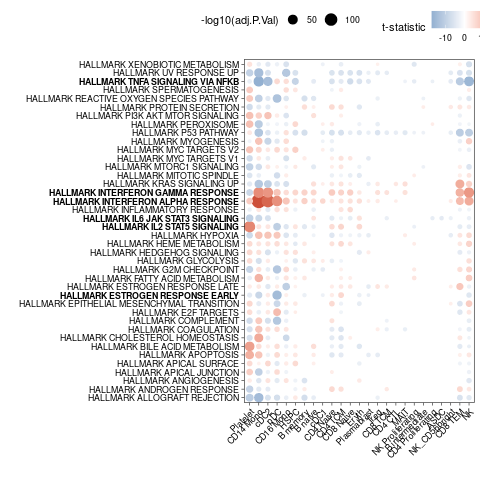

In [282]:
%%R
ggplot(subset(ggdat, adj.P.Val < 0.05), aes(y=pathway, x = level_2)) +
    geom_point(aes(size = -log10(adj.P.Val), color = t)) +  
#     scale_color_distiller(palette = 'RdBu', name = 't-statistic') +
    scale_colour_gradient2(low = "steelblue", mid = "white", high = "tomato3", na.value = "00000000",name = 't-statistic') +
#     geom_text(aes(label = signif), size = 1.9, color = 'black') + 
    theme_linedraw() + 
#     coord_flip() + 
#     scale_size_continuous(breaks = c(1, 10, 50, 100)) + 
    theme(axis.text.x = element_text(angle = 45,  hjust=1, color='black'), 
          legend.position="top", 
          panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
          axis.text.y = element_text(face = bold.labels)) +
    xlab('') + ylab('') + labs(fill = expression(-log[10]~FDR))

In [283]:
%%R
table(ggdat$adj.P.Val > 0.05)

[1] 482 518


In [284]:
%%R
ggsave("figures/heatmap_HallmarkPathways_celltypes_COVIDseverequery_alpha4pt5_miloDE.png", units="in", width=8, height=8, dpi=200)

In [233]:
# %%R
# unique(pernhood_dge$pathway)

In [234]:
# %%R
# # check DE results for pDC:  any significan activity for mTOR
# pernhood_dge[pernhood_dge$level_2 == "pDC" & pernhood_dge$pathway == 'HALLMARK_MTORC1_SIGNALING',]

In [235]:
# %%R
# # check DE results for pDC:  any significan activity for mTOR
# pernhood_dge[pernhood_dge$level_2 == "pDC" & pernhood_dge$pathway == 'HALLMARK_PI3K_AKT_MTOR_SIGNALING',]

In [236]:
celltypecol = umap_adata.uns['celltype_colors'] 
# conditioncol = umap_adata.uns['Resp_colors']

In [237]:
%%R
df <- pernhood_dge[,c('pathway','Nhood.Group','t')]
M <- tidyr::spread(df, "pathway",'t')
rownames(M) <- M$'Nhood.Group'
M$Nhood.Group <- NULL

In [276]:
%%R
print(head(pernhood_dge))

                                                     logFC     AveExpr
NhoodGroup1.HALLMARK_INTERFERON_GAMMA_RESPONSE  0.11960238  0.03017558
NhoodGroup1.HALLMARK_INTERFERON_ALPHA_RESPONSE  0.06844768  0.01366650
NhoodGroup1.HALLMARK_HEME_METABOLISM            0.03134416 -0.00469291
NhoodGroup1.HALLMARK_P53_PATHWAY               -0.06269088  0.03298014
NhoodGroup1.HALLMARK_TNFA_SIGNALING_VIA_NFKB   -0.06405967  0.08006142
NhoodGroup1.HALLMARK_COMPLEMENT                -0.04572503  0.13880470
                                                       t      P.Value
NhoodGroup1.HALLMARK_INTERFERON_GAMMA_RESPONSE  7.356057 5.073788e-13
NhoodGroup1.HALLMARK_INTERFERON_ALPHA_RESPONSE  3.957543 8.307439e-05
NhoodGroup1.HALLMARK_HEME_METABOLISM            3.892902 1.080651e-04
NhoodGroup1.HALLMARK_P53_PATHWAY               -3.548204 4.125201e-04
NhoodGroup1.HALLMARK_TNFA_SIGNALING_VIA_NFKB   -3.444104 6.054598e-04
NhoodGroup1.HALLMARK_COMPLEMENT                -3.293461 1.037021e-03
             

In [238]:
%%R
df_sig <- pernhood_dge[,c('pathway','Nhood.Group','adj.P.Val')]
M_sig <- tidyr::spread(df_sig, "pathway",'adj.P.Val')
rownames(M_sig) <- M_sig$'Nhood.Group'
M_sig$Nhood.Group <- NULL

In [239]:
%%R
M[M_sig > 0.05] <- 0

In [240]:
# %%R
# print(head(M[,1:10]))

In [241]:
%%R
nhood_names <- rownames(M)
rownames(M) <- paste0('NhoodGroup_', rownames(M))

In [242]:
%%R
# head(mdata)

NULL


In [243]:
%%R
head(nhoodgroup_ann[nhood_names])

          1          10         100         101         102         103 
       "NK"        "NK" "CD14 Mono"   "CD4 TCM"       "pDC" "CD4 Naive" 


In [244]:
df_colmap = pd.DataFrame.from_dict(col_map, orient = "index")

In [245]:
%%R -i df_colmap
df_colmap

                          0
CD8 Proliferating   #edc951
CD8 Naive           #eb6841
NK Proliferating    #cc2a36
NK                  #4f372d
NK_CD56bright       #00a0b0
ILC                 #51394E
CD8 TCM             #C8AF8A
CD8 TEM             #658385
CD4 TEM             #B04838
CD4 TCM             #3F6F76
CD4 Naive           #C65840
CD14 Mono           #d2981a
CD4 Proliferating   #62496F
CD4 CTL             #69B7CE
CD16 Mono           #a53e1f
Treg                #457277
MAIT                #8f657d
cDC1                #8dcee2
cDC2                #91323A
pDC                 #3A4960
Plasmablast         #6D7345
Platelet            #C1AE8D
HSPC                #D7C969
B naive             #C1395E
gdT                 #AEC17B
B memory            #E07B42
B intermediate      #89A7C2
Eryth               #F0CA50
ASDC                #67161C
dnT                 #3F6148
Healthy             #A4804C
severe              #4B5F80
mod                 #DBD3A4
query               #654E92
reference           

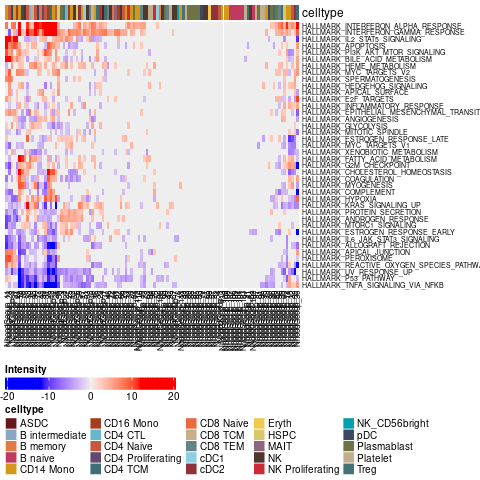

In [246]:
%%R 



# heatmap of per-nhood results for supp:
celltypecol <- df_colmap[,1]
names(celltypecol) <- rownames(df_colmap)
ha_column <- HeatmapAnnotation(celltype = nhoodgroup_ann[nhood_names][order(nhoodgroup_ann[nhood_names])],
                              
                               col = list(celltype = celltypecol),
                              annotation_legend_param = list(
                                    celltype = list(ncol = 5)
                                  ))

hm <- Heatmap(t(M),
column_title = "",
              name = "Intensity",
#               col = inferno(20),
              show_row_names = TRUE,
              show_column_names = TRUE,
              cluster_rows = TRUE,
              cluster_columns = TRUE,
              show_column_dend = FALSE,
              show_row_dend = FALSE,
              top_annotation = ha_column,
              row_names_gp =  gpar(fontsize = 7),
              column_names_gp = gpar(fontsize = 8),
              heatmap_legend_param = list(direction = "horizontal",
              heatmap_legend_side = "bottom",
#               labels = levels(mdata$predicted_l2_scarches),
              legend_width = unit(6, "cm")),
              
         )
hm <- draw(hm, heatmap_legend_side = "bottom", annotation_legend_side = "bottom")

In [247]:
%%R
dim(M)

[1] 113  40


In [277]:
%%R
png(file="figures/diff_gp_activity_heatmap.png", height=700, width=800) # res=200


hm <- Heatmap(t(M)[,order(nhoodgroup_ann[nhood_names])],
column_title = "Neighborhood Groups",
              name = "Intensity",
#               col = inferno(20),
#               col = gplots::colorpanel(256,low="white",high="red2"),
#               col = gplots::colorpanel(100,low = "steelblue", mid = "white", high = "tomato3"),
              col = circlize::colorRamp2(c(-15, 0, 15), c("steelblue", "white", "tomato3")),
              show_row_names = TRUE,
              show_column_names = FALSE,
              cluster_rows = TRUE,
              cluster_columns = FALSE,
              show_column_dend = FALSE,
              show_row_dend = FALSE,
              top_annotation = ha_column,
              row_names_gp =  gpar(fontsize = 12),
              column_names_gp = gpar(fontsize = 11),
              row_names_max_width = unit(12, "cm"),
              heatmap_legend_param = list(#direction = "horizontal",
              heatmap_legend_side = "bottom",
#               labels = levels(mdata$predicted_l2_scarches),
              legend_width = unit(25, "cm")),
         )
draw(hm,  heatmap_legend_side = "left", annotation_legend_side = "bottom")

dev.off()

[1] 2


In [285]:
%%R
print(head(rownames(M)))
print(head(colnames(M)))

[1] "NhoodGeoup_1"   "NhoodGeoup_10"  "NhoodGeoup_100" "NhoodGeoup_101"
[5] "NhoodGeoup_102" "NhoodGeoup_103"
[1] "HALLMARK_ALLOGRAFT_REJECTION" "HALLMARK_ANDROGEN_RESPONSE"  
[3] "HALLMARK_ANGIOGENESIS"        "HALLMARK_APICAL_JUNCTION"    
[5] "HALLMARK_APICAL_SURFACE"      "HALLMARK_APOPTOSIS"          


In [286]:
%%R
dim(t(M)[,order(nhoodgroup_ann[nhood_names])])

[1]  40 113


In [288]:
%%R
print(table(nhoodgroup_ann))

nhoodgroup_ann
             ASDC    B intermediate          B memory           B naive 
                1                 1                 1                 7 
        CD14 Mono         CD16 Mono           CD4 CTL         CD4 Naive 
               18                 5                 1                 8 
CD4 Proliferating           CD4 TCM         CD8 Naive           CD8 TCM 
                1                 8                 2                 2 
          CD8 TEM              cDC1              cDC2             Eryth 
                5                 2                 5                 1 
             HSPC              MAIT                NK  NK Proliferating 
                3                 1                13                 2 
    NK_CD56bright               pDC       Plasmablast          Platelet 
                1                 5                11                 8 
             Treg 
                1 


In [298]:
%%R
sum(table(nhoodgroup_ann))

[1] 113


In [311]:
%%R
M_new = t(M)[,order(nhoodgroup_ann[nhood_names])]
celltype_new = nhoodgroup_ann[nhood_names][order(nhoodgroup_ann[nhood_names])]

keep_celltypes = c('Plasmablast','CD14 Mono','Platelet','pDC')
keep_pathways = c("HALLMARK_TNFA_SIGNALING_VIA_NFKB",
                   "HALLMARK_IL2_STAT5_SIGNALING",
                   "HALLMARK_IL6_JAK_STAT3_SIGNALING",
                  "HALLMARK_ESTROGEN_RESPONSE_EARLY",
                  "HALLMARK_INTERFERON_ALPHA_RESPONSE",
                  "HALLMARK_INTERFERON_GAMMA_RESPONSE")


M_new = M_new[rownames(M_new) %in% keep_pathways, celltype_new %in% keep_celltypes]
celltype_new = celltype_new[celltype_new %in% keep_celltypes]

In [349]:
%%R

png(file="figures/diff_gp_activity_heatmap_mainfig.png", height=600, width=500) # res=200

# subset of the heatmap for main figure

ha_row <- rowAnnotation(celltype = celltype_new,
                              
                               col = list(celltype = celltypecol[names(celltypecol) %in% keep_celltypes]),
                              annotation_legend_param = list(
                                    celltype = list(ncol = 1, title=" ") 
                                  ), show_legend = FALSE)


hm <- Heatmap(t(M_new),
row_title = "",
             
              name = "Intensity",
#               col = inferno(20),
#               col = gplots::colorpanel(256,low="white",high="red2"),
#               col = gplots::colorpanel(100,low = "steelblue", mid = "white", high = "tomato3"),
              col = circlize::colorRamp2(c(-15, 0, 15), c("steelblue", "white", "tomato3")),
              show_row_names = FALSE,
              show_column_names = TRUE,
              cluster_rows = FALSE,
              cluster_columns = FALSE,
              show_column_dend = FALSE,
              show_row_dend = FALSE,
#               top_annotation = ha_column,
              right_annotation = ha_row,
               column_names_rot = 45,
              row_names_gp =  gpar(fontsize = 12),
              column_names_gp = gpar(fontsize = 11),
              row_names_max_width = unit(12, "cm"),
              width = ncol(t(M_new))*unit(5, "mm"),
              heatmap_legend_param = list(direction = "horizontal",
              heatmap_legend_side = "bottom",
#               labels = levels(mdata$predicted_l2_scarches),
              legend_width = unit(3, "cm")),
         )
draw(hm,  heatmap_legend_side = "bottom", annotation_legend_side = "bottom")
dev.off()

[1] 2


In [ ]:
# %%R
# pernhood_dge <- pernhood_dge[pernhood_dge$adj.P.Val < 0.05,]
# print(dim(pernhood_dge))
# head(pernhood_dge[pernhood_dge$logFC > log2(1.1),], n= 30)

In [ ]:
# %%R
# milo

In [ ]:
# %%R
# dim(nhoodExpression(milo))

In [ ]:
# %%R
# nhoodExpression(milo)

In [ ]:
# %%R
# plotNhoodExpressionDA(
#     milo,
#     da.res,
#     features = "HALLMARK_IL2_STAT5_SIGNALING",
#     alpha = 0.1,
#     subset.nhoods = NULL,
#     cluster_features = FALSE,
#     assay = "X",
#     scale_to_1 = FALSE,
#     show_rownames = TRUE,
#     highlight_features = NULL
# )

### Differential abundance and gene program activity: Days from onset

In [ ]:
%%R
print(table(colData(gp_adata)$Resp))

In [ ]:
%%R
library(splines)

X <- ns(as.numeric(sample_annot$days_from_onset), df=3)

orig_ident <- sample_annot$orig_ident
design_co <- model.matrix(~X)

print(head(design_co))

In [ ]:
# %%R
# rownames(design_co) <- rownames(sample_annot)

In [ ]:
# %%R
# print(rownames(sample_annot))
# print(rownames(design_co))
# print(colnames(nhoodCounts(milo_co)))

In [ ]:
%%R
print(table(sample_annot$days_from_onset))

In [ ]:
%%R
day_status_map <- c('2' = 'early','8'='mid','9' = 'mid','15'='late','16'='late', 'NA' = 'healthy') 
Day <- day_status_map[as.character(sample_annot$days_from_onset)]
Day[is.na(Day)] <- 'healthy'
sample_annot$Day <- factor(Day, levels = c('healthy','early', 'mid','late'))

In [ ]:
%%R
print(table(Day))

In [ ]:
%%R
head(sample_annot)

In [ ]:
%%R

design_co <- model.matrix(~Resp, data = sample_annot)

print(head(design_co))

In [ ]:
%%R
da_results_donset <- testNhoods(milo, design = design_co, 
                         design.df = sample_annot,
                         reduced.dim = 'UMAP',
#                          model.contrasts = c('Daymid - Daylate')
                         model.contrasts = c('Respsevere')
                        ) 

In [ ]:
%%R
head(da_results_donset)

In [ ]:
%%R
plotNhoodGraphDA(milo, da_results_donset, alpha=0.1)

In [ ]:
%%R
print(table(da_results_donset$SpatialFDR < 0.05))

In [ ]:
%%R
print(table(da_results_donset$PValue < 0.05))

In [ ]:
%%R
da_results_donset <- annotateNhoods(milo, da_results_donset, "predicted_l2_scarches")

In [ ]:
%%R
head(da_results_donset)

In [ ]:
%%R
plotDAbeeswarm(da_results_donset, group.by = 'predicted_l2_scarches', alpha = 0.05) + xlab('') + scale_color_distiller(palette = 'RdBu') 

In [ ]:
%%R
da.res <- groupNhoods(milo, da_results_donset, da.fdr=0.05)

In [ ]:
%%R

Day <- day_status_map[as.character(mdata$days_from_onset)]
Day[is.na(Day)] <- 'healthy'
mdata$Day <- factor(Day, levels = c('healthy','early', 'mid','late'))

In [ ]:
%%R
# head(model.matrix(~Day, data = mdata))

In [ ]:
%%R
print(dim(model.matrix(~Day, data = mdata)))

In [ ]:
%%R
print(head(model.matrix(~Day, data = mdata)))

In [ ]:
%%R
nhood.dge.daymid <- testDiffExp(milo, da.res, 
#                          subset.nhoods = as.numeric(unique(da.res$Nhood[da.res$predicted_l2_scarches %in% 
#                                                            c('Plasmablast')])),
                         design=~Day , meta.data=mdata,  
                         n.coef = 3,
#                          model.contrasts = c('Daylate - Daymid'),
                         assay = "logcounts"
                        )
nhood.dge.daymid

In [ ]:
%%R
nhood.dge.daylate <- testDiffExp(milo, da.res, 
#                          subset.nhoods = as.numeric(unique(da.res$Nhood[da.res$predicted_l2_scarches %in% 
#                                                            c('Plasmablast')])),
                         design=~Day , meta.data=mdata,  
                         n.coef = 4,
#                          model.contrasts = c('Daylate - Daymid'),
                         assay = "logcounts"
                        )
nhood.dge.daylate

In [ ]:
%%R
milo